```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict

# 讀檔

In [2]:
validation_traj = np.load(f'./all_user_match_data.npy', allow_pickle=True)

In [3]:
valid_data = validation_traj.item()

In [4]:
valid_data = validation_traj.item()
pose_set = set()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            pose_set.add(posture_name)
print(pose_set)

{'target', 'swing', 'pocket', 'horizontal', 'front_pocket'}


'cord_y', 'cord_x', 'times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t'

In [5]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            mag = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

            pos_mag = np.concatenate((pos, mag), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [6]:
# for posture_name in posture_data.keys():
#     print([d.shape for d in posture_data[posture_name]])

In [7]:
posture_data.keys()

dict_keys(['front_pocket', 'horizontal', 'pocket', 'swing', 'target'])

In [8]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [9]:
prep_valid_front_pocket_traj = split_traj(posture_data['front_pocket'])
prep_valid_horizontal_traj = split_traj(posture_data['horizontal'])
prep_valid_pocket_traj = split_traj(posture_data['pocket'])
prep_valid_swing_traj = split_traj(posture_data['swing'])
prep_valid_target_traj = split_traj(posture_data['target'])

In [10]:
# def expand_seq_features(seq):
#     ### neighbors
#     s_cord = seq[:, :, 0:2]
#     s_mag = seq[:, :, 2:5]
    
#     s_magT = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2) + np.power(s_mag[:, :, 2:3], 2))
#     s_magH = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))  # magH
#     s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
#     # n_azimuth_angle = 0
    
#     print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_elevation_angle.shape)
#     s_new = np.concatenate([s_cord, s_mag, s_magT, s_magH, s_elevation_angle], axis=-1)
    
#     return s_new

In [11]:
# prep_valid_front_pocket_traj = expand_seq_features(prep_valid_front_pocket_traj)
# prep_valid_horizontal_traj = expand_seq_features(prep_valid_horizontal_traj)
# prep_valid_pocket_traj = expand_seq_features(prep_valid_pocket_traj)
# prep_valid_swing_traj = expand_seq_features(prep_valid_swing_traj)
# prep_valid_target_traj = expand_seq_features(prep_valid_target_traj)

In [12]:
prep_valid_front_pocket_traj.shape, prep_valid_horizontal_traj.shape, prep_valid_pocket_traj.shape, prep_valid_swing_traj.shape, prep_valid_target_traj.shape

((674, 20, 15), (674, 20, 15), (674, 20, 15), (674, 20, 15), (674, 20, 15))

In [13]:
datapoint_per_second = 20
duration = 2
seq_len = 10
classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [16]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [17]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
#     print(source_total_mag.shape, target_total_mag.shape, pred_total_mag.shape)
#     print(source_total_mag[0])
#     print(target_total_mag[0])
#     print(pred_total_mag[0])
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [18]:
# train_source_data.shape, train_source_label.shape, train_target_data.shape, train_target_label.shape

In [19]:
# train
t_data = np.concatenate((prep_valid_front_pocket_traj[0::2], prep_valid_horizontal_traj[0::2], prep_valid_pocket_traj[0::2], prep_valid_swing_traj[0::2]))
t_target_data = np.concatenate((prep_valid_target_traj[0::2], prep_valid_target_traj[0::2], prep_valid_target_traj[0::2], prep_valid_target_traj[0::2]))

train_source_data = t_data
train_source_label = (np.arange(4) + 1).repeat(len(t_data)/4)
train_target_data = t_target_data
train_target_label = np.zeros((len(t_data) * 4, ))
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# valid
v_data = np.concatenate((prep_valid_front_pocket_traj[1::2], prep_valid_horizontal_traj[1::2], prep_valid_pocket_traj[1::2], prep_valid_swing_traj[1::2]))
v_target_data = np.concatenate((prep_valid_target_traj[1::2], prep_valid_target_traj[1::2], prep_valid_target_traj[1::2], prep_valid_target_traj[1::2]))

valid_source_data = v_data
valid_source_label = (np.arange(4) + 1).repeat(len(v_data)/4)
valid_target_data = v_target_data
valid_target_label = np.zeros((len(v_data) * 4, ))
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [20]:
train_source_data.shape, train_source_label.shape, valid_source_data.shape, valid_source_label.shape

((1348, 20, 15), (1348,), (1348, 20, 15), (1348,))

In [21]:
# train_dataset[0][0], train_dataset[337][0], train_dataset[674][0]

In [22]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [23]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag
        

In [25]:
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [26]:
output = model(torch.empty(16, 10, 9).to(device), torch.empty(16, 10, 3).to(device))
output[0].shape, output[1].shape

(torch.Size([16, 10, 9]), torch.Size([16, 10, 3]))

In [27]:
from torchinfo import summary
summary(model, input_size=[(1, 10, 9), (1, 10, 3)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 10, 9]                --
├─Sequential: 1-1                             [1, 10, 64]               --
│    └─Linear: 2-1                            [1, 10, 32]               320
│    └─LeakyReLU: 2-2                         [1, 10, 32]               --
│    └─Linear: 2-3                            [1, 10, 64]               2,112
│    └─LeakyReLU: 2-4                         [1, 10, 64]               --
├─PositionalEncoding: 1-2                     [1, 10, 64]               --
│    └─Dropout: 2-5                           [1, 10, 64]               --
├─Sequential: 1-3                             [1, 10, 64]               --
│    └─Linear: 2-6                            [1, 10, 16]               64
│    └─LeakyReLU: 2-7                         [1, 10, 16]               --
│    └─Linear: 2-8                            [1, 10, 64]               1,088
│    └─LeakyR

In [28]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [29]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        source_mag = source_data[:, :, 11:14] + torch.randn_like(source_data[:, :, 11:14]) * 0.5
        source_total_mag = source_data[:, :, 14]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]
        target_mag = target_data[:, :, 11:14]
        target_total_mag = target_data[:, :, 14]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [30]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:14]
            source_total_mag = source_data[:, :, 14]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:14]
            target_total_mag = target_data[:, :, 14]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

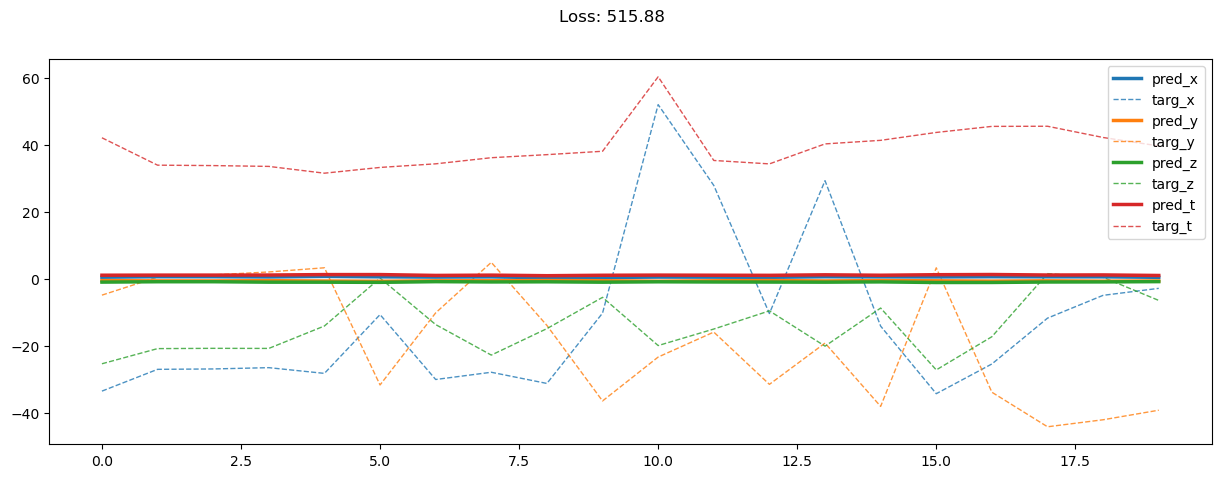

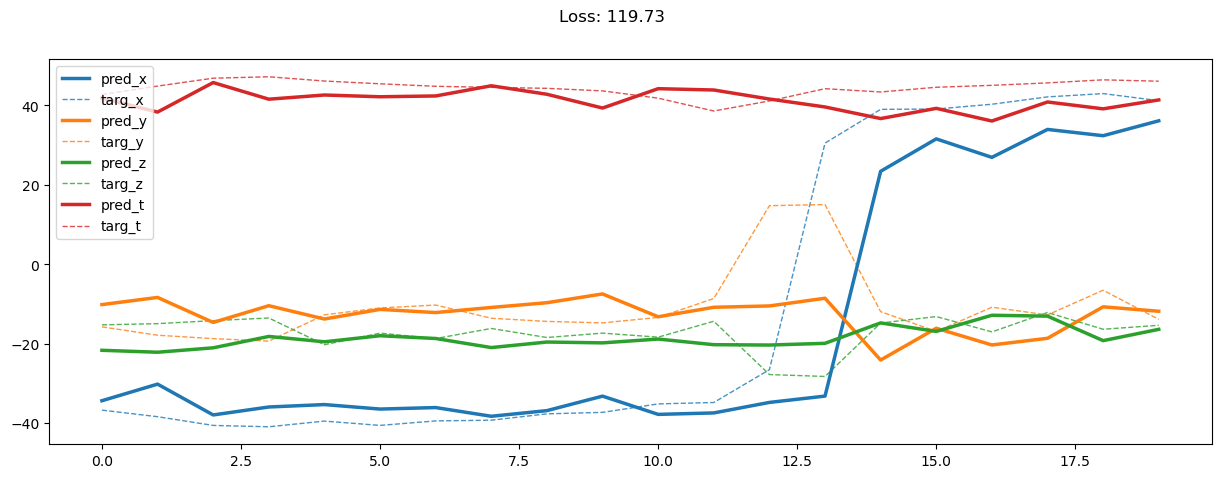

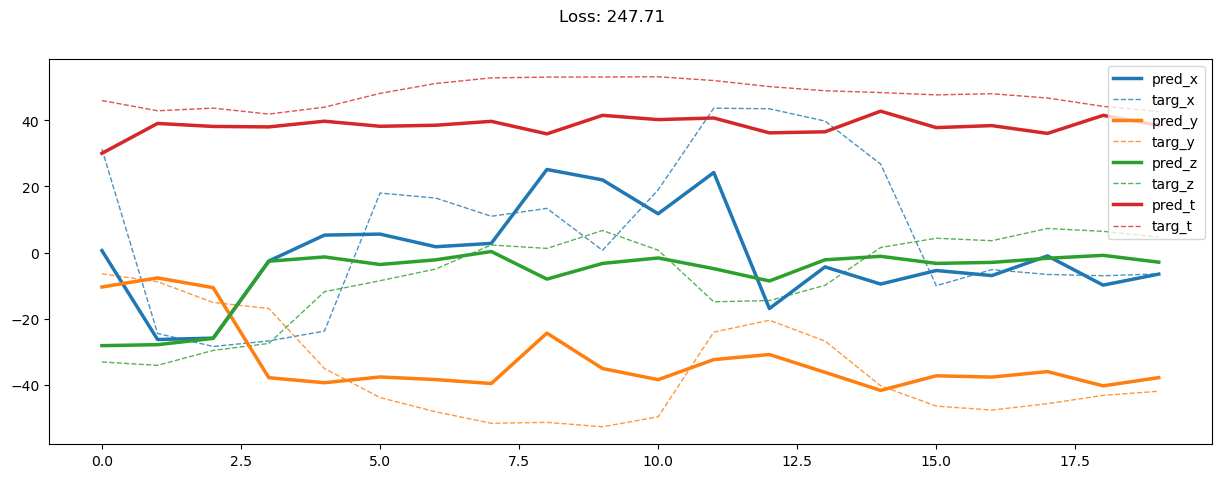

01000: train loss:  470.163, imu loss:  0.596, mag loss:  154.192, div loss:  308.263, slim:  7.658, tlim:  6.929
       valid loss:  299.420, imu loss:  0.604, mag loss:  131.283, div loss:  161.621, slim:  6.478, tlim:  5.724


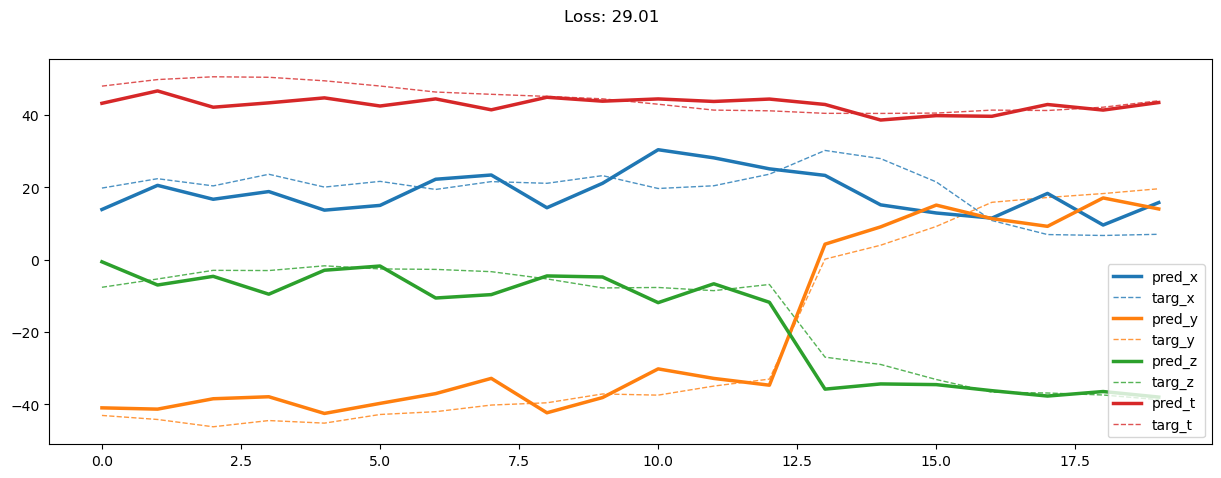

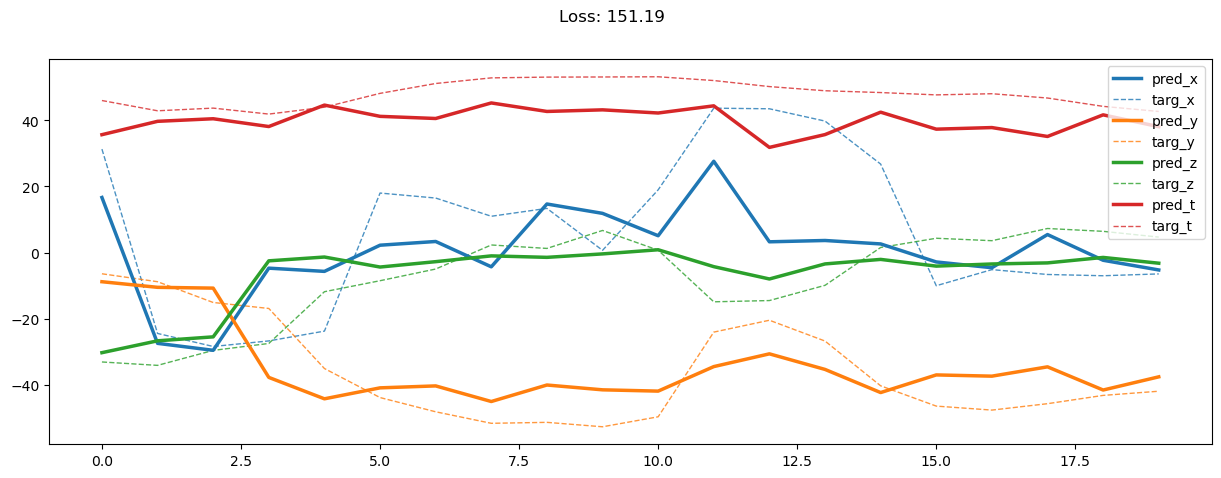

02000: train loss:  350.961, imu loss:  0.564, mag loss:  114.992, div loss:  229.449, slim:  6.598, tlim:  5.741
       valid loss:  218.570, imu loss:  0.563, mag loss:  87.577, div loss:  125.618, slim:  5.592, tlim:  4.552


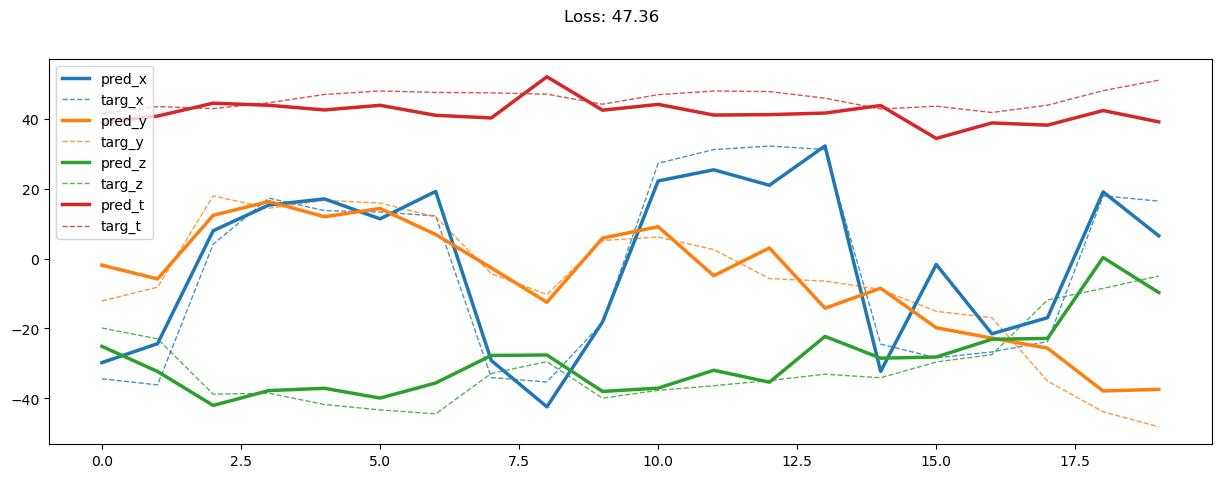

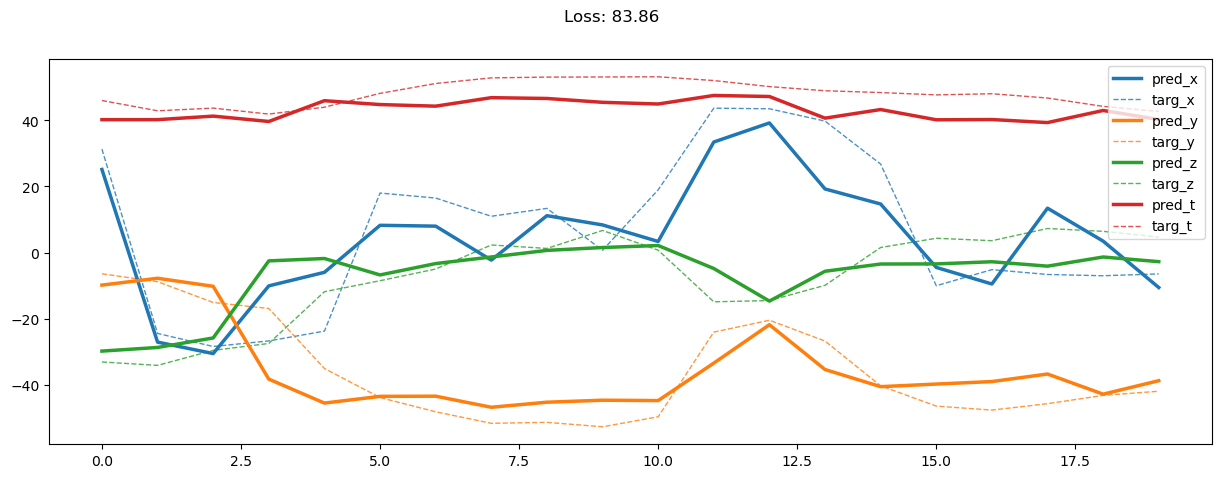

03000: train loss:  295.253, imu loss:  0.548, mag loss:  96.847, div loss:  192.436, slim:  6.245, tlim:  5.148
       valid loss:  170.313, imu loss:  0.543, mag loss:  64.521, div loss:  100.959, slim:  5.189, tlim:  3.991


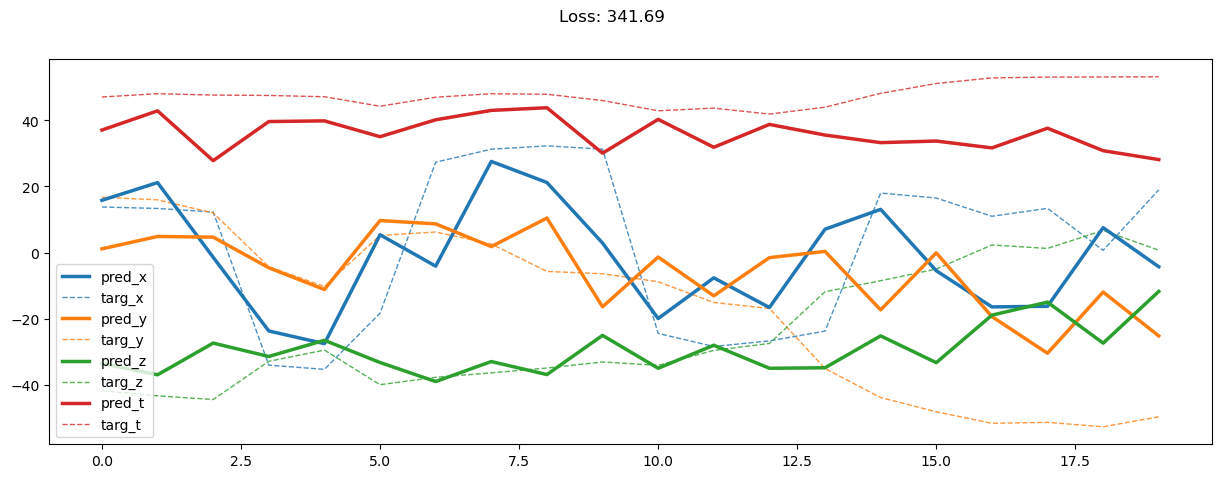

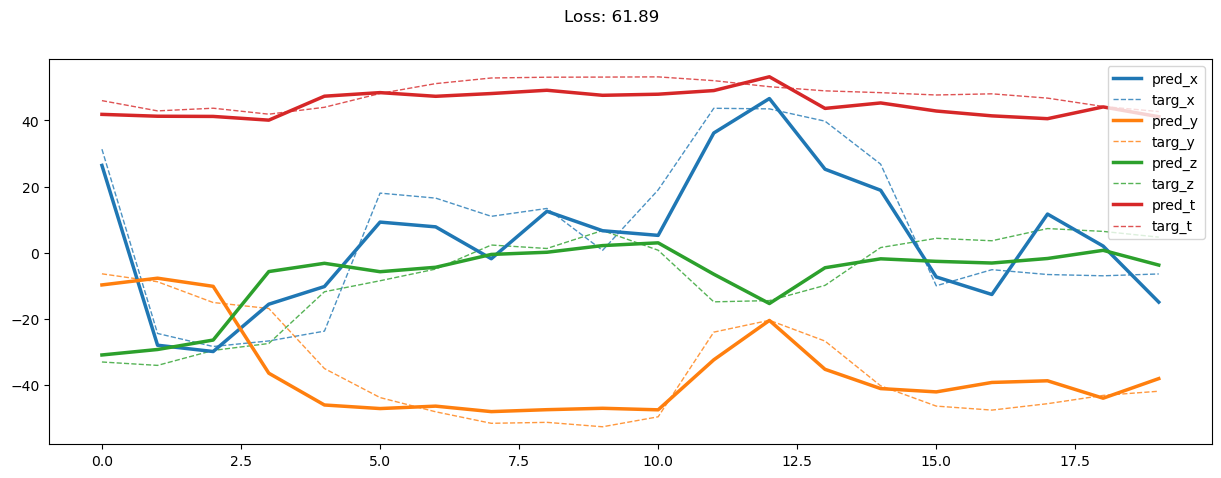

04000: train loss:  256.954, imu loss:  0.566, mag loss:  83.960, div loss:  167.411, slim:  5.895, tlim:  4.725
       valid loss:  141.761, imu loss:  0.524, mag loss:  51.575, div loss:  85.792, slim:  4.855, tlim:  3.542


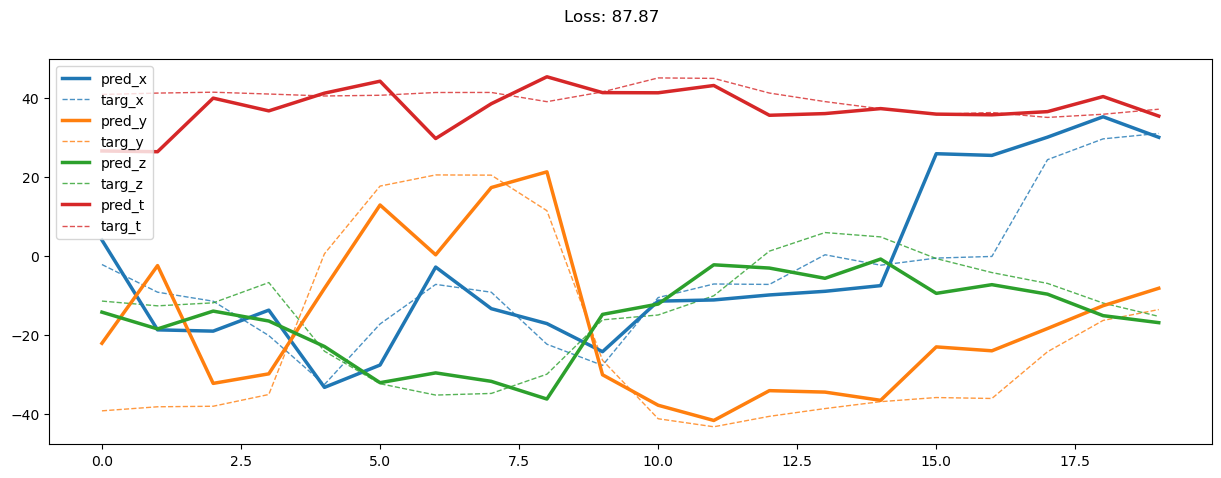

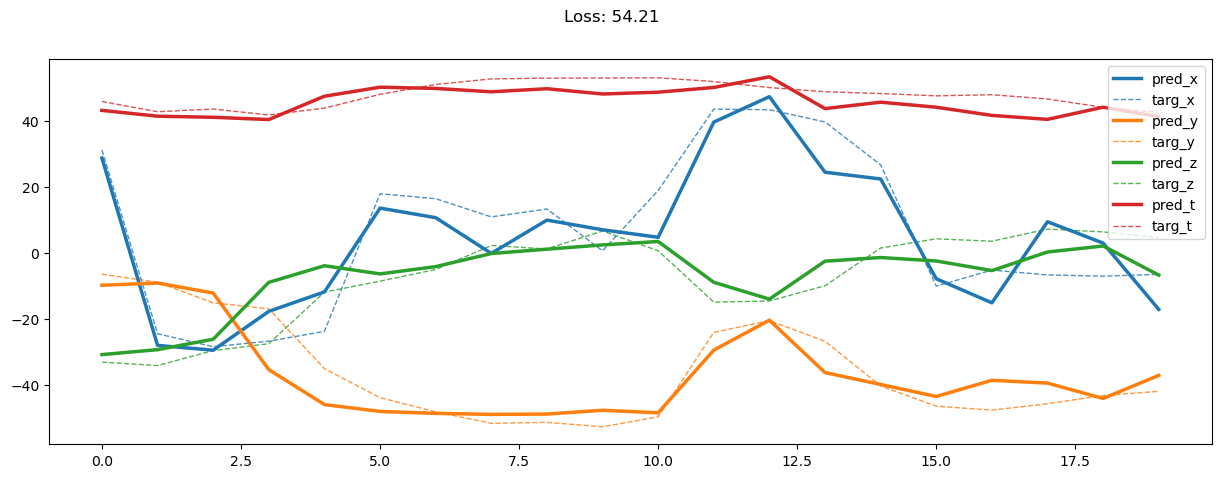

05000: train loss:  222.642, imu loss:  0.530, mag loss:  72.807, div loss:  144.696, slim:  5.560, tlim:  4.291
       valid loss:  119.970, imu loss:  0.511, mag loss:  42.318, div loss:  73.561, slim:  4.663, tlim:  3.219


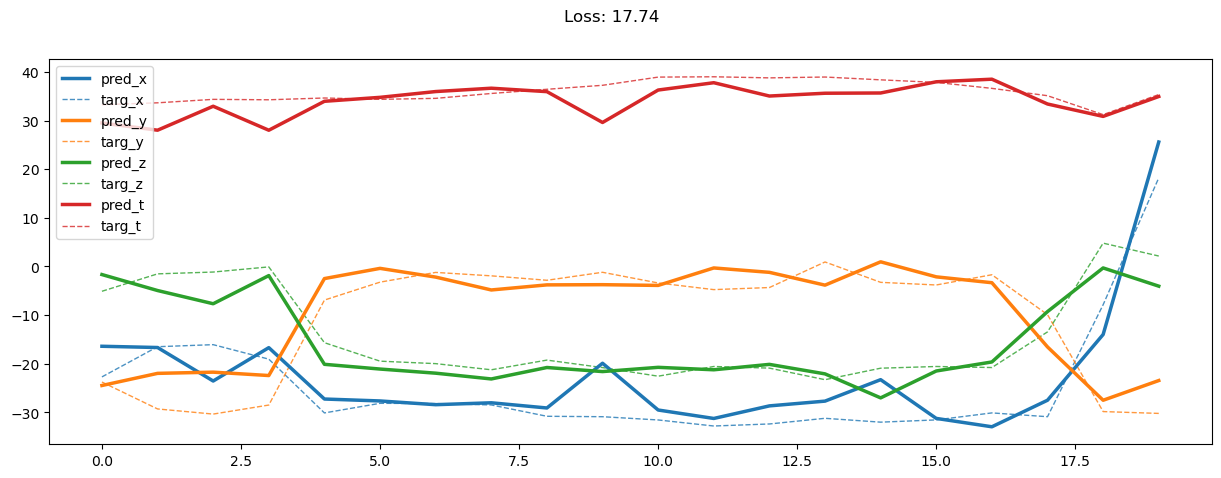

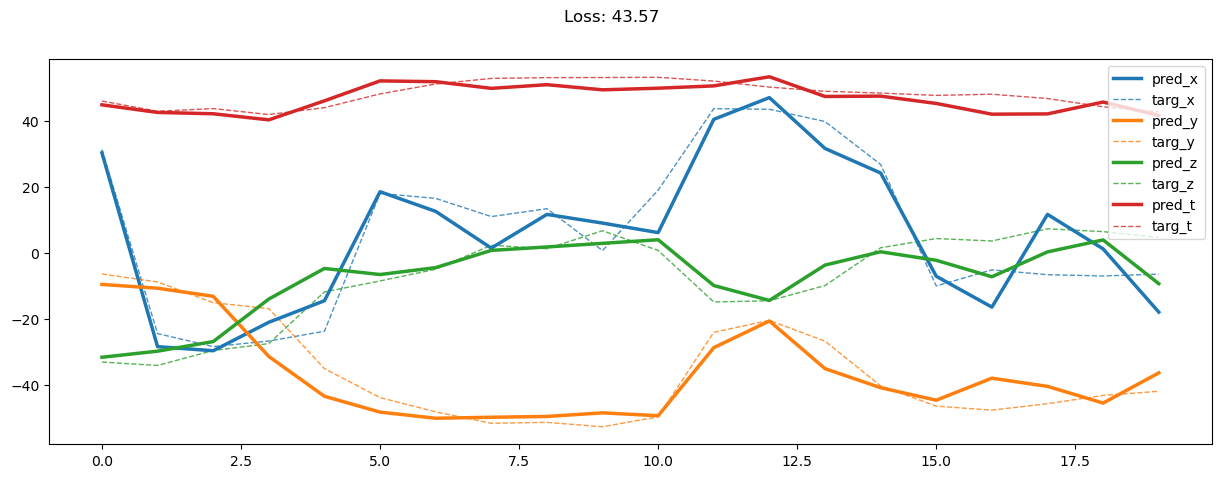

06000: train loss:  190.157, imu loss:  0.520, mag loss:  61.811, div loss:  123.574, slim:  5.239, tlim:  3.923
       valid loss:  101.603, imu loss:  0.502, mag loss:  35.374, div loss:  62.350, slim:  4.545, tlim:  2.987


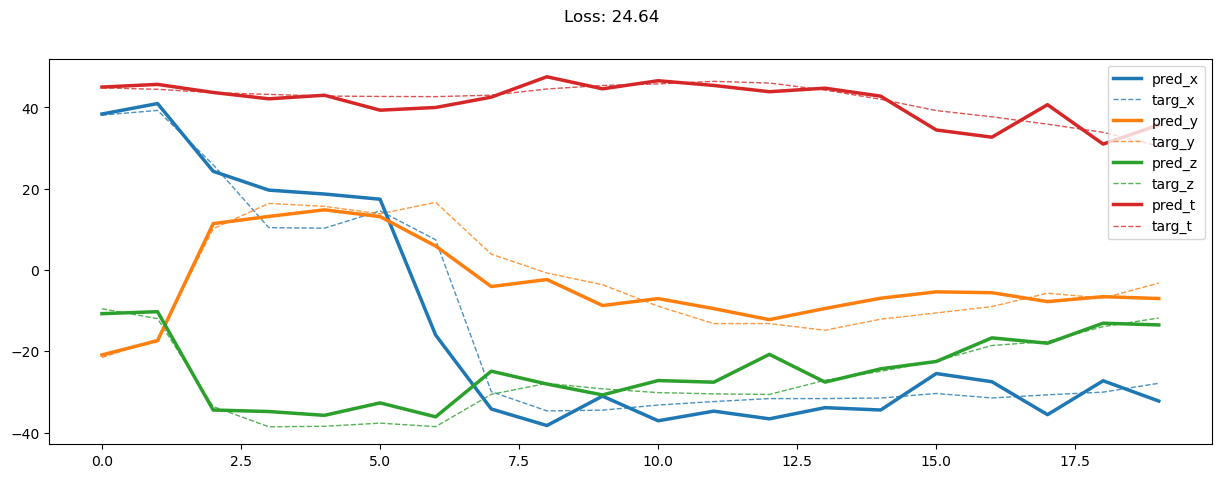

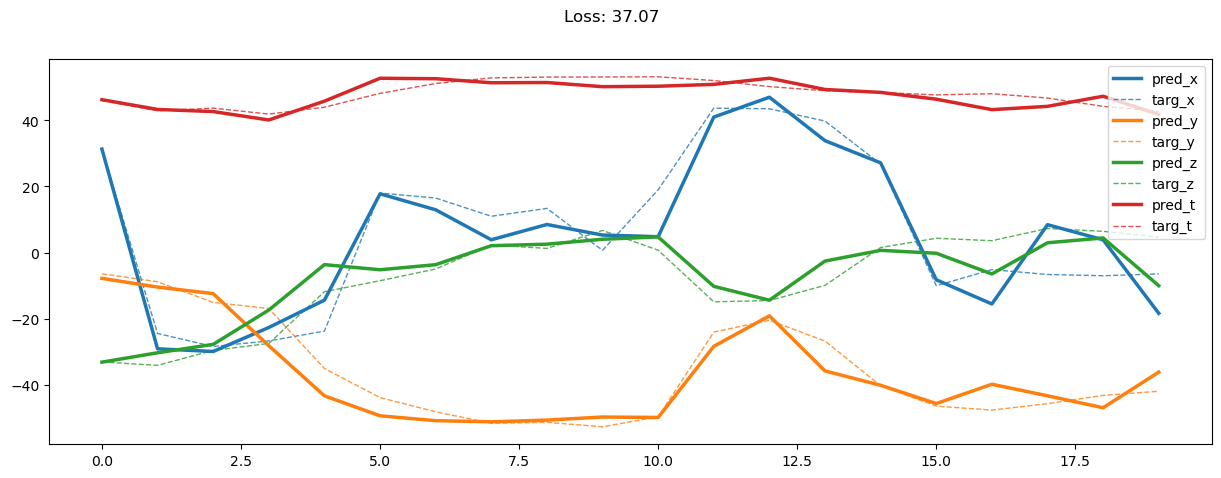

07000: train loss:  167.283, imu loss:  0.512, mag loss:  54.110, div loss:  108.661, slim:  5.030, tlim:  3.656
       valid loss:  87.995, imu loss:  0.494, mag loss:  30.290, div loss:  53.931, slim:  4.506, tlim:  2.871


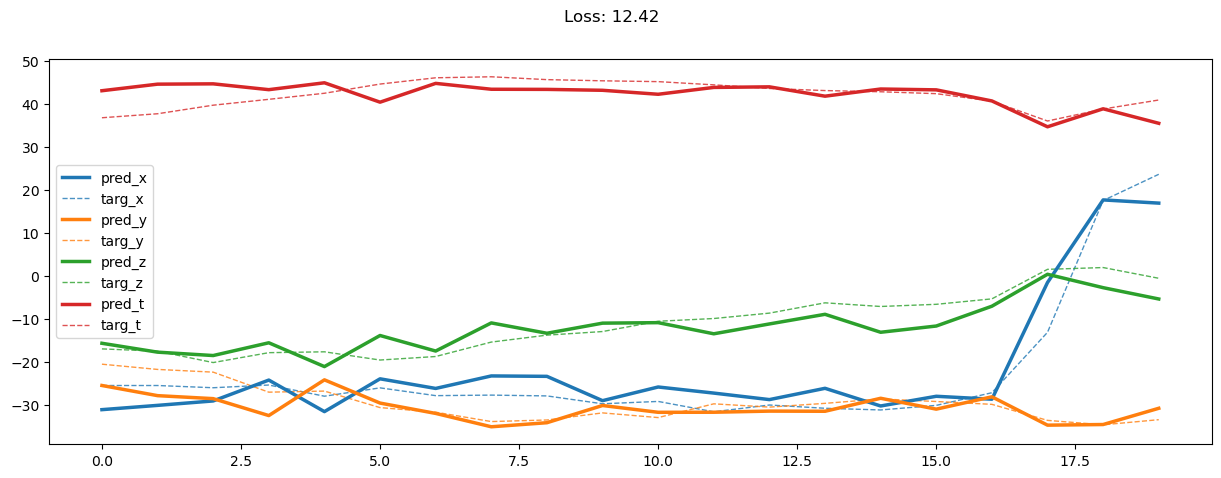

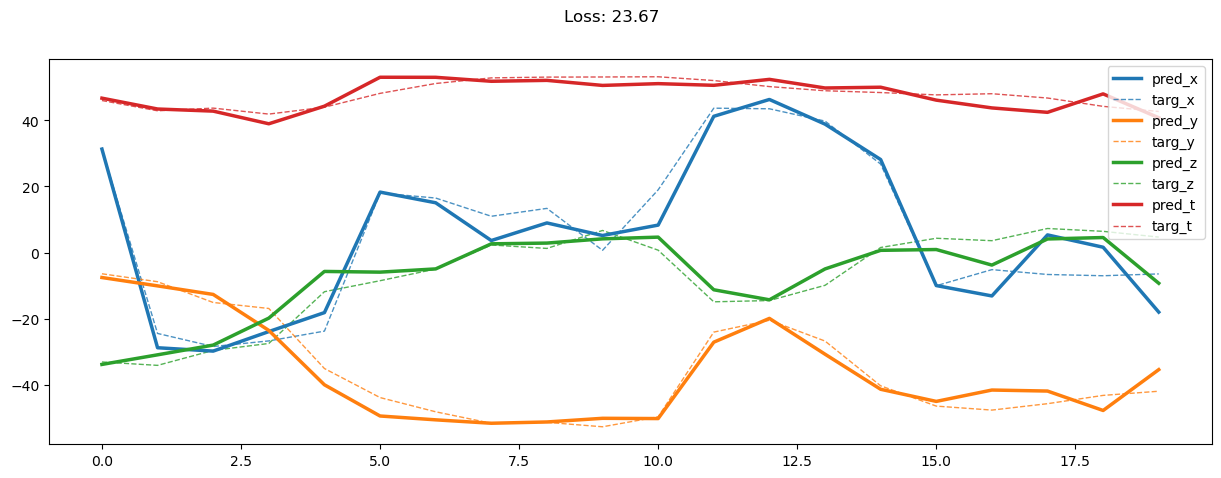

08000: train loss:  158.220, imu loss:  0.510, mag loss:  51.832, div loss:  101.932, slim:  5.058, tlim:  3.574
       valid loss:  77.542, imu loss:  0.488, mag loss:  26.542, div loss:  47.370, slim:  4.434, tlim:  2.712


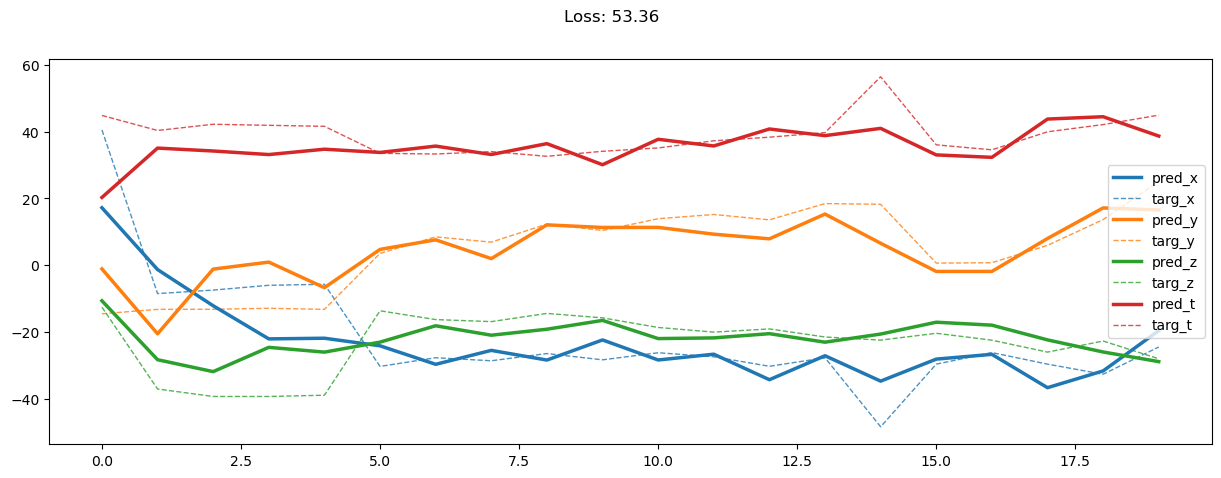

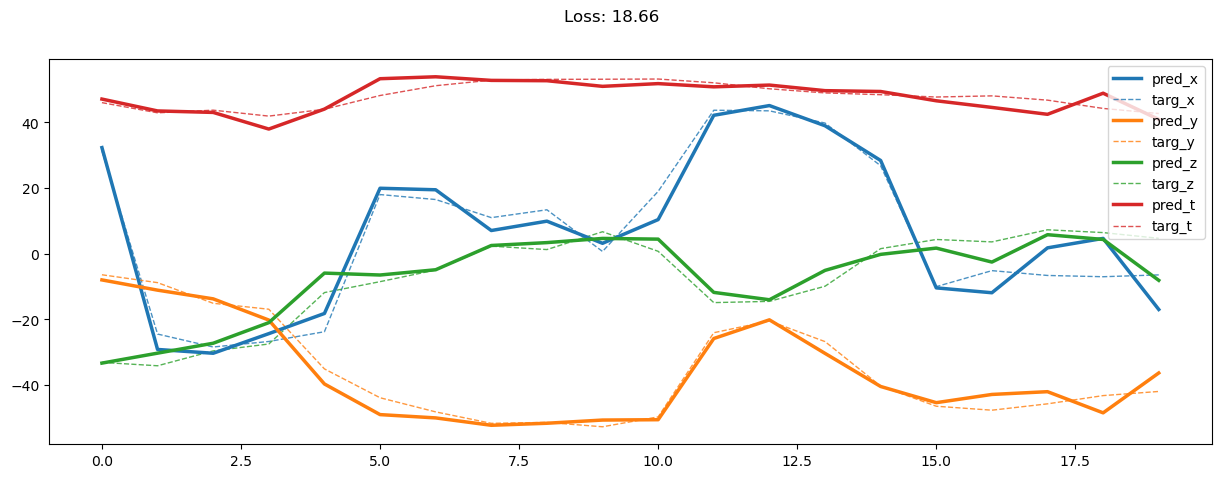

09000: train loss:  144.461, imu loss:  0.520, mag loss:  46.910, div loss:  93.236, slim:  4.976, tlim:  3.402
       valid loss:  69.166, imu loss:  0.483, mag loss:  23.452, div loss:  42.202, slim:  4.393, tlim:  2.574


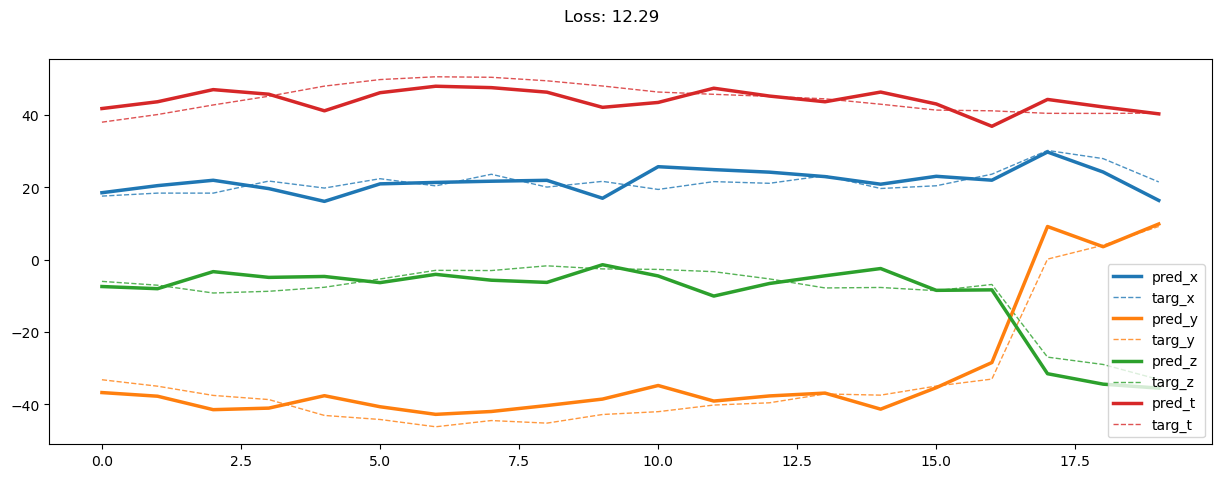

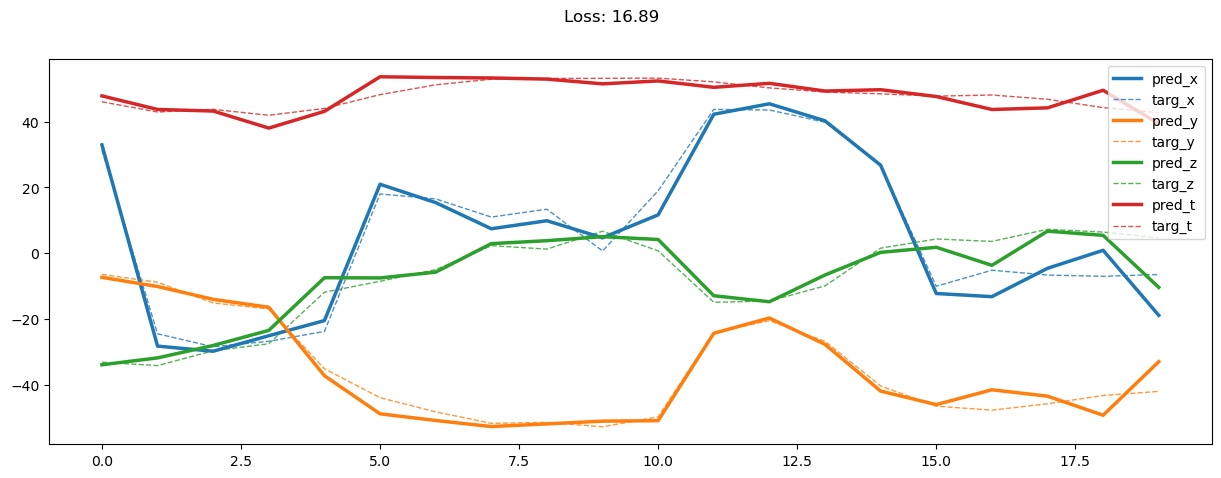

10000: train loss:  127.335, imu loss:  0.496, mag loss:  41.233, div loss:  81.977, slim:  4.819, tlim:  3.233
       valid loss:  63.612, imu loss:  0.479, mag loss:  21.458, div loss:  38.658, slim:  4.414, tlim:  2.552


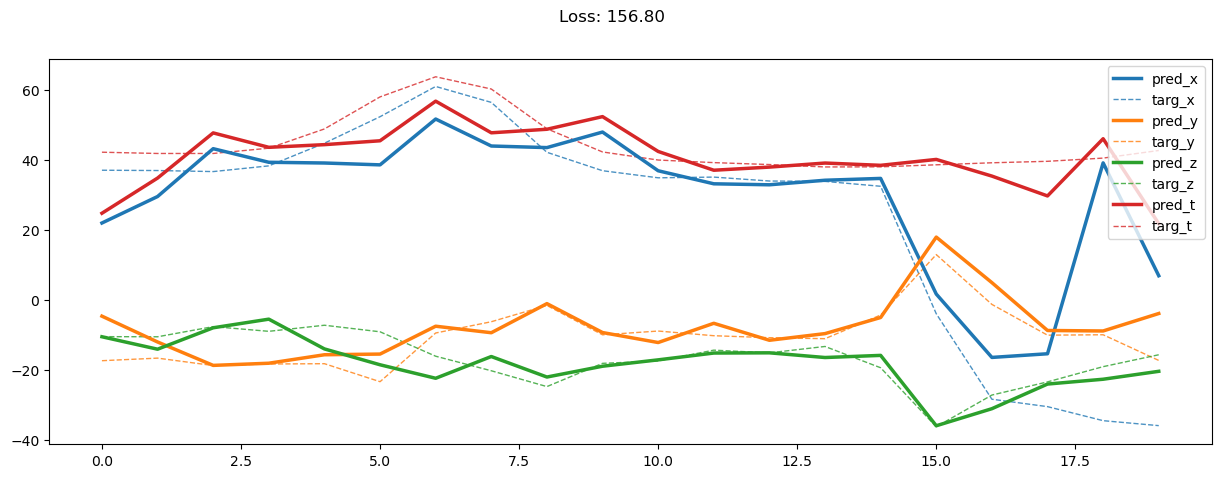

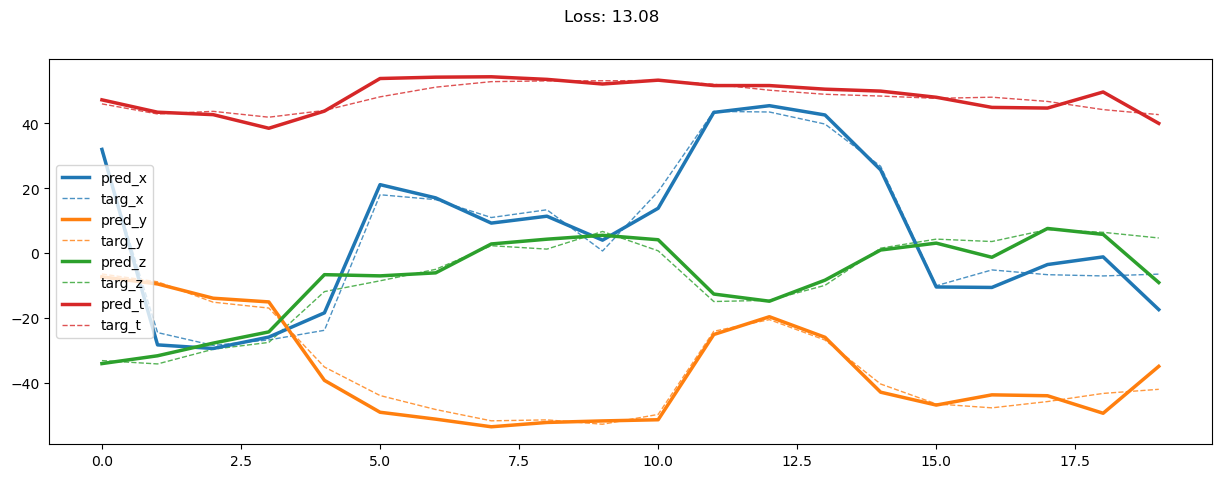

11000: train loss:  124.308, imu loss:  0.492, mag loss:  40.174, div loss:  80.026, slim:  4.957, tlim:  3.170
       valid loss:  57.210, imu loss:  0.475, mag loss:  19.122, div loss:  34.686, slim:  4.366, tlim:  2.447


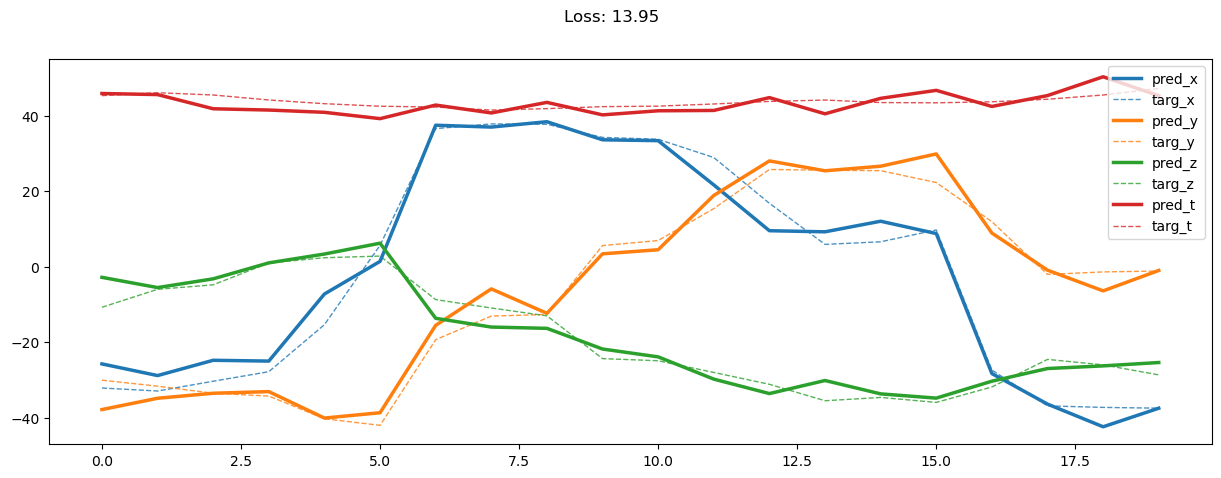

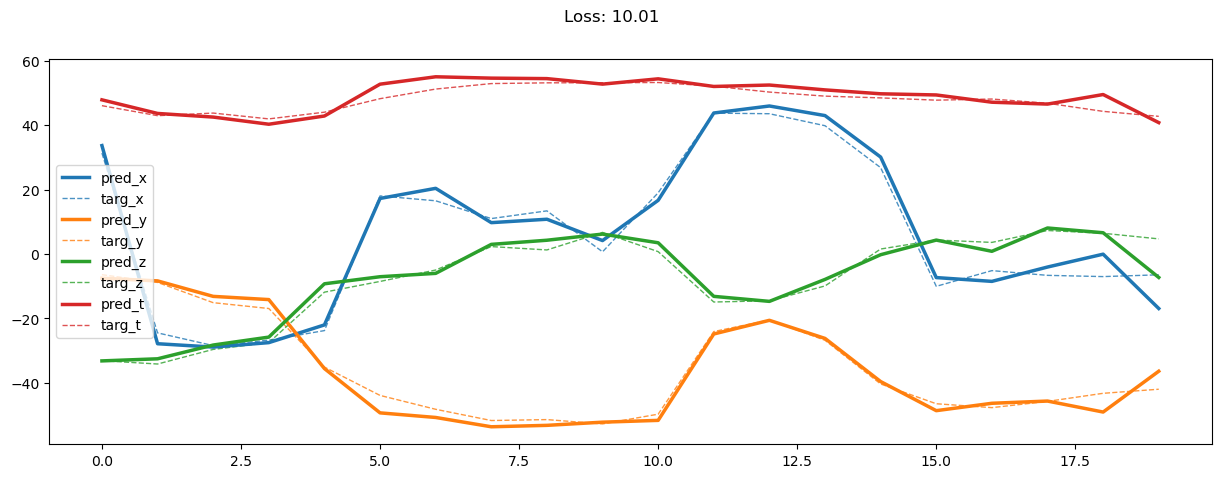

12000: train loss:  113.426, imu loss:  0.494, mag loss:  36.773, div loss:  72.735, slim:  4.706, tlim:  2.997
       valid loss:  52.603, imu loss:  0.471, mag loss:  17.557, div loss:  31.622, slim:  4.392, tlim:  2.474


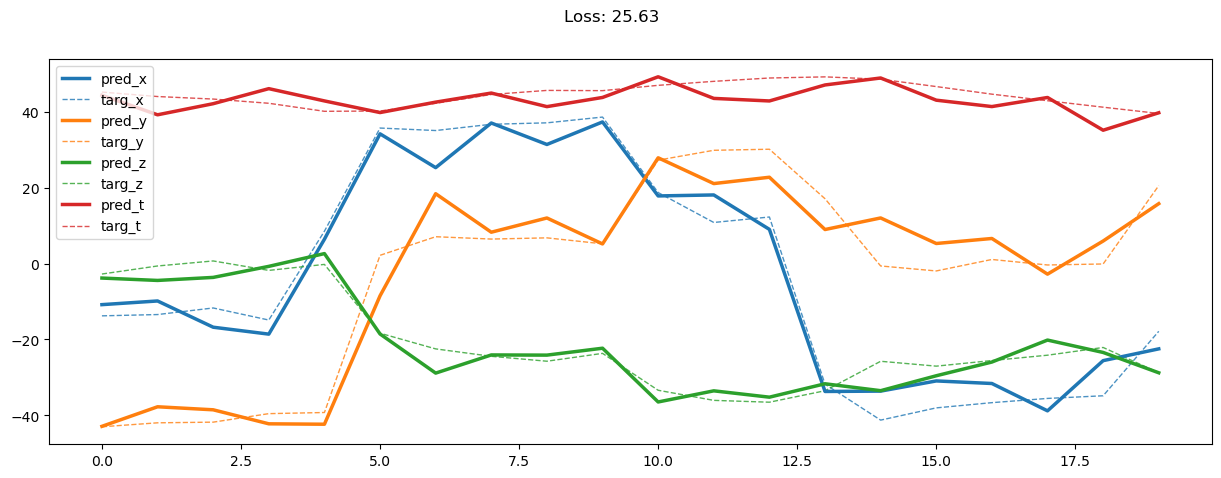

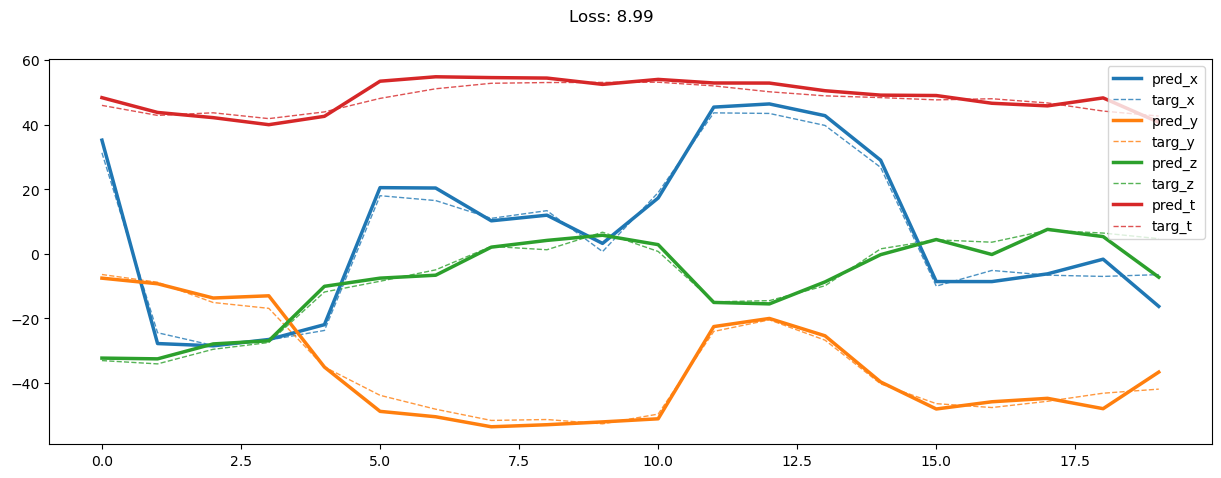

13000: train loss:  106.372, imu loss:  0.486, mag loss:  34.186, div loss:  68.306, slim:  4.810, tlim:  2.921
       valid loss:  48.718, imu loss:  0.468, mag loss:  16.206, div loss:  29.140, slim:  4.384, tlim:  2.410


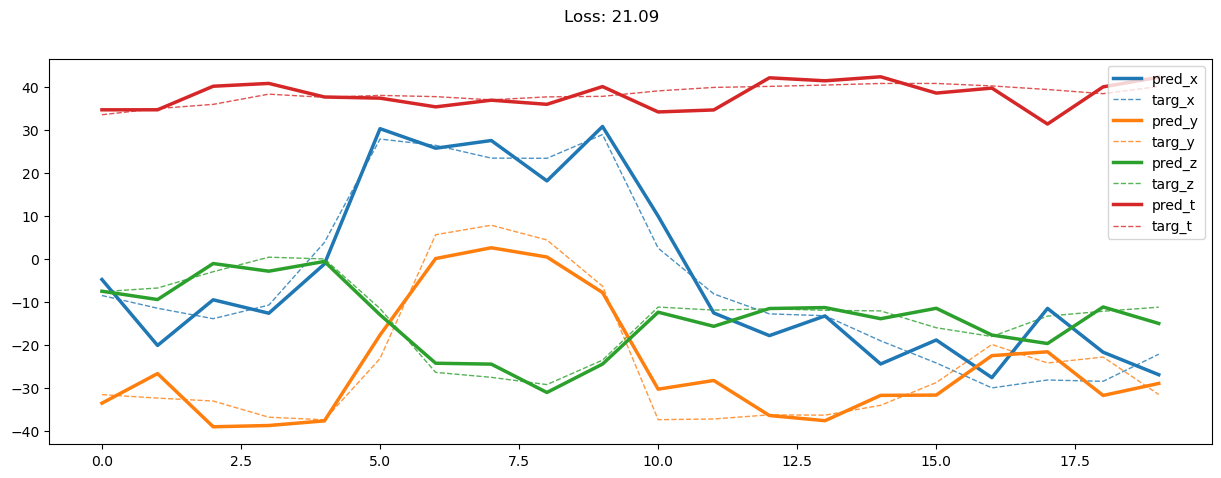

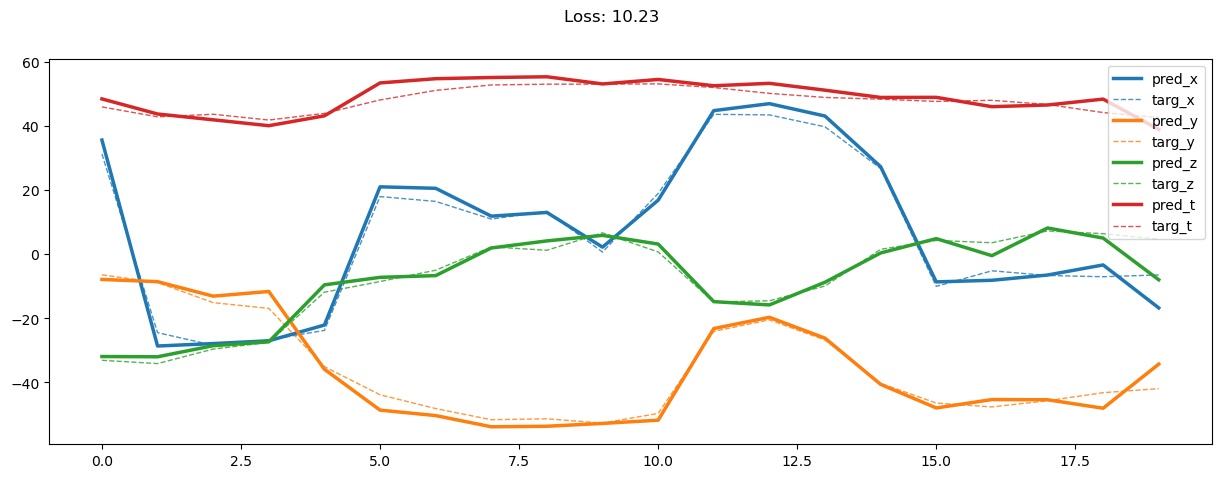

14000: train loss:  101.957, imu loss:  0.490, mag loss:  32.775, div loss:  65.427, slim:  4.626, tlim:  2.812
       valid loss:  44.965, imu loss:  0.466, mag loss:  14.926, div loss:  26.696, slim:  4.376, tlim:  2.378


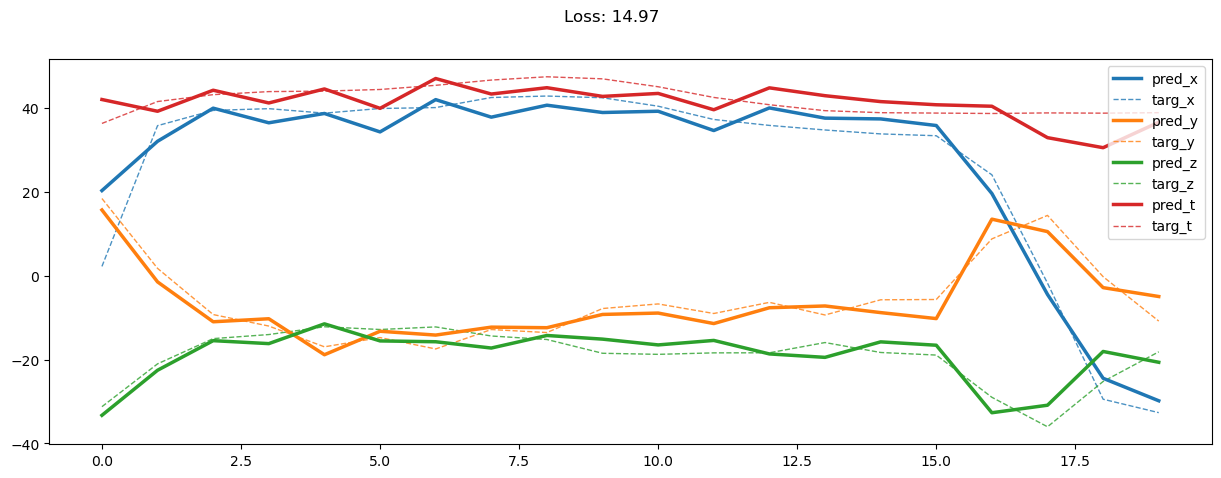

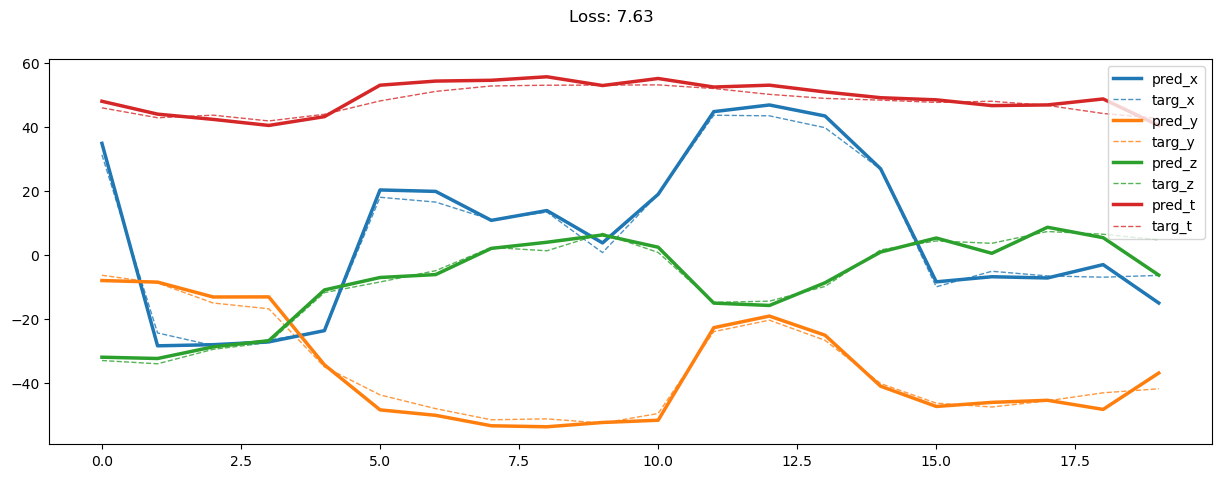

15000: train loss:  98.187, imu loss:  0.530, mag loss:  31.713, div loss:  62.672, slim:  4.666, tlim:  2.807
       valid loss:  43.913, imu loss:  0.463, mag loss:  14.492, div loss:  26.133, slim:  4.381, tlim:  2.306


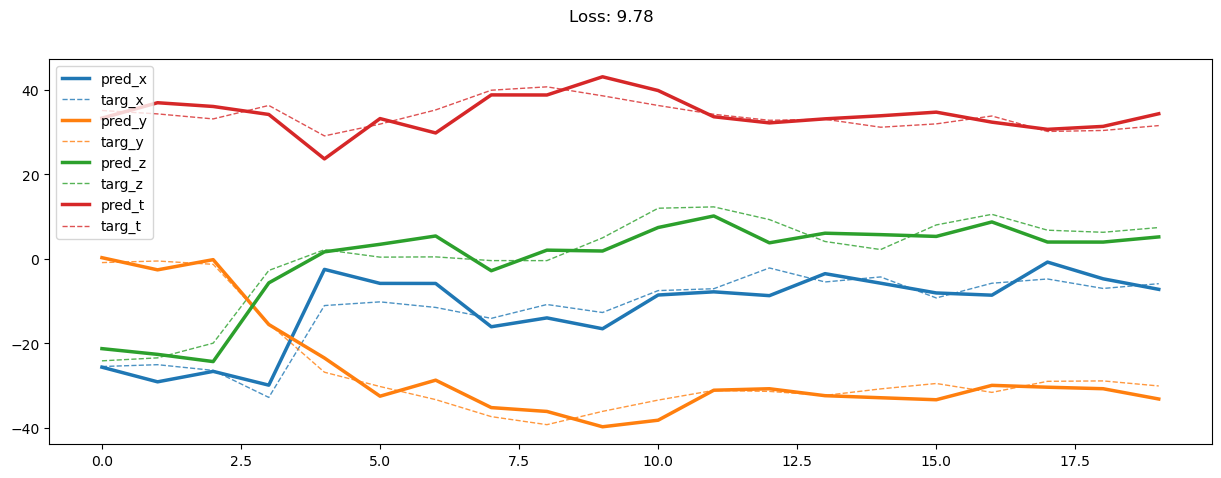

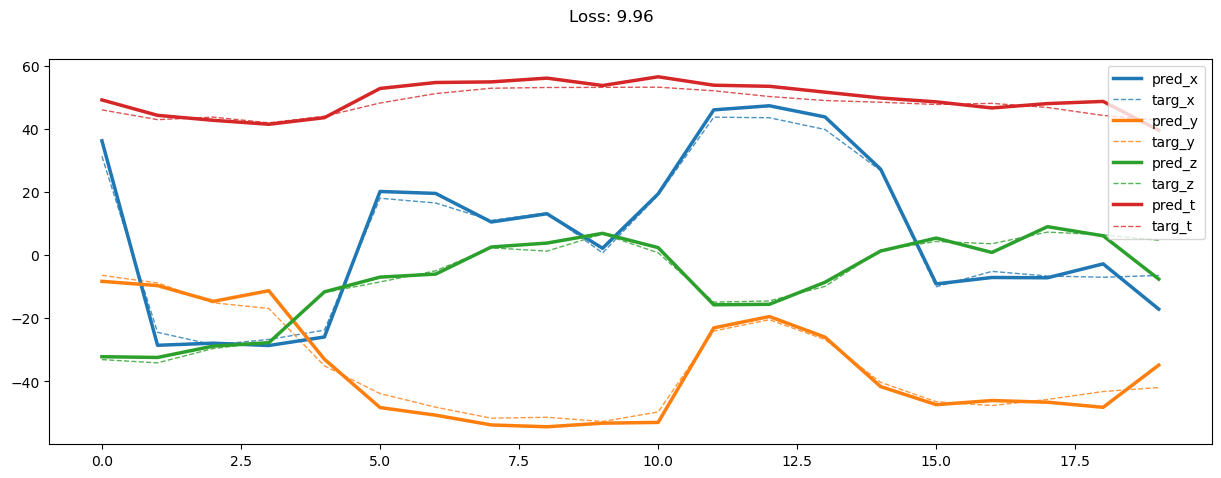

16000: train loss:  92.116, imu loss:  0.481, mag loss:  29.473, div loss:  59.002, slim:  4.532, tlim:  2.704
       valid loss:  41.010, imu loss:  0.460, mag loss:  13.546, div loss:  24.159, slim:  4.392, tlim:  2.329


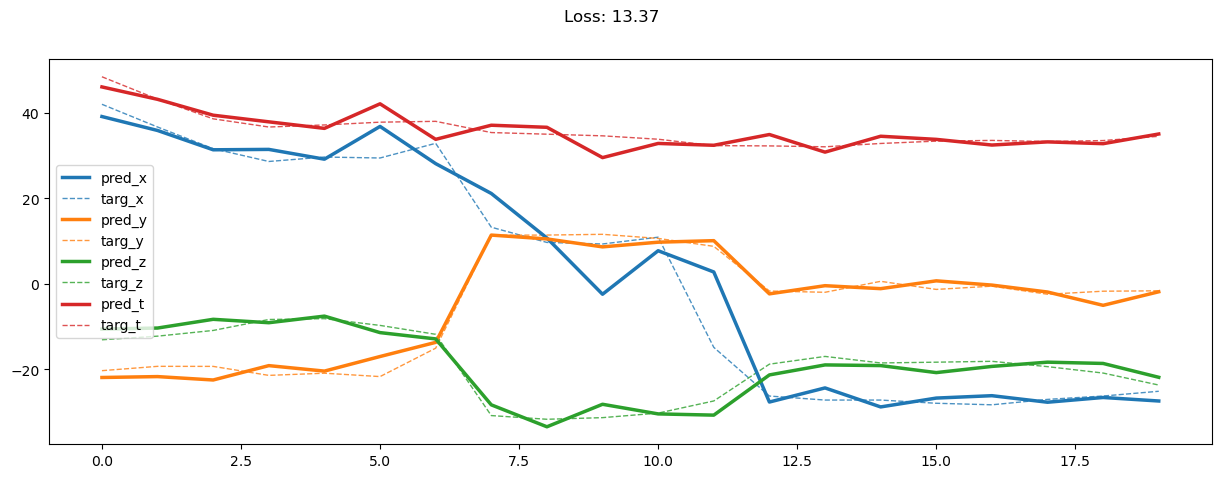

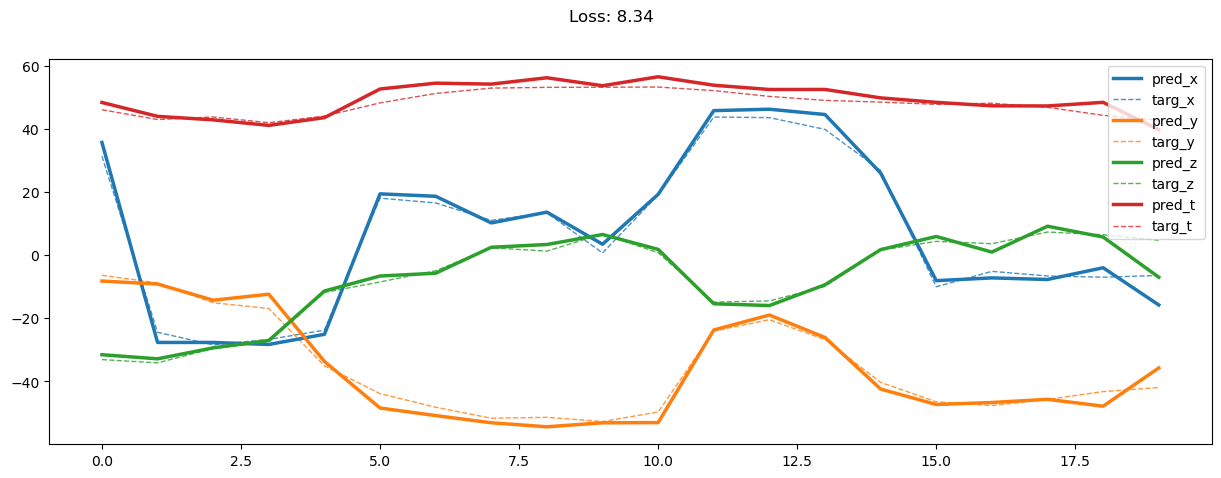

17000: train loss:  89.923, imu loss:  0.480, mag loss:  28.739, div loss:  57.572, slim:  4.659, tlim:  2.622
       valid loss:  42.029, imu loss:  0.457, mag loss:  13.837, div loss:  24.977, slim:  4.376, tlim:  2.217


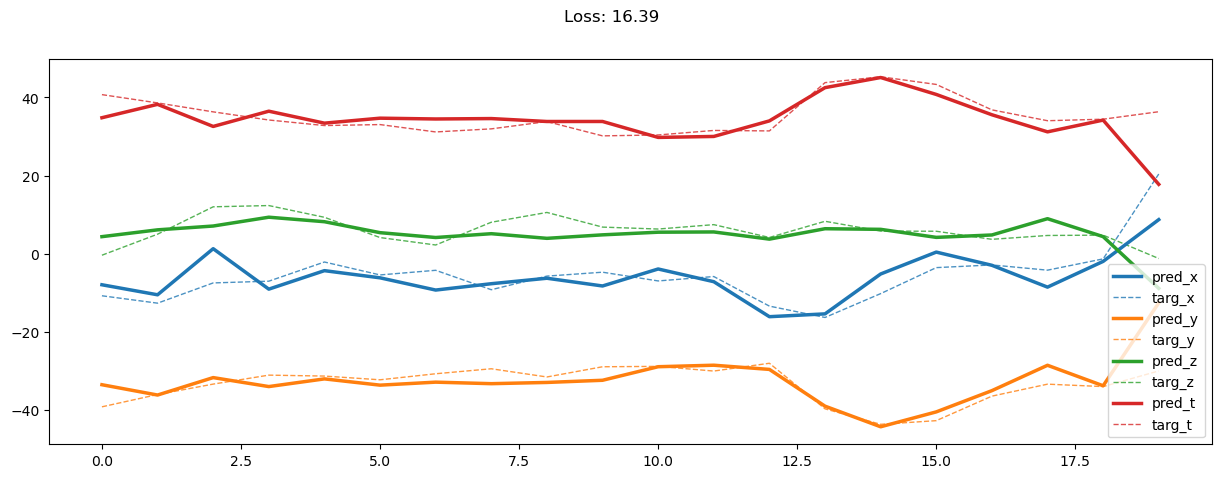

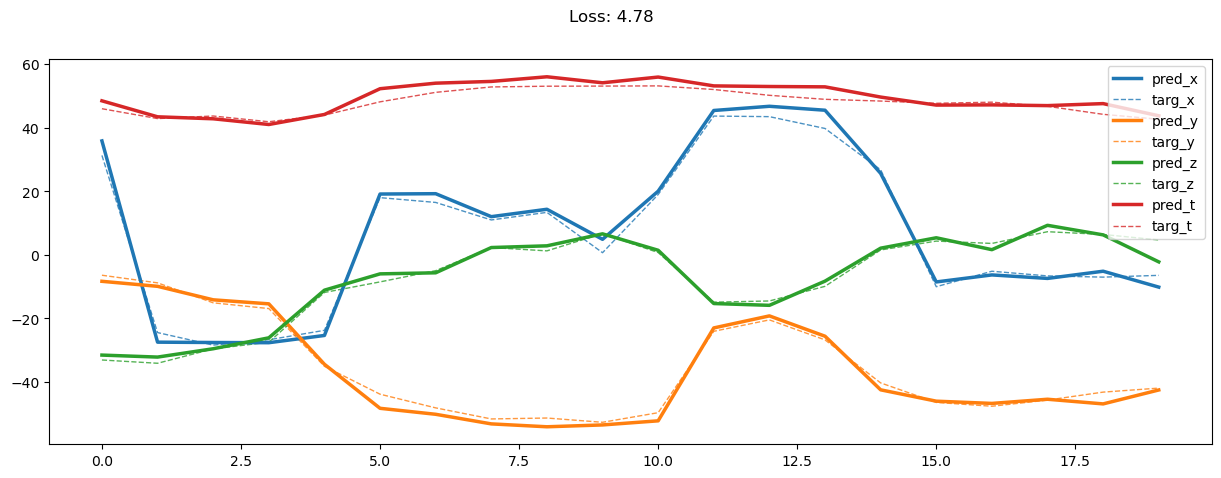

18000: train loss:  92.778, imu loss:  0.476, mag loss:  29.969, div loss:  59.187, slim:  4.602, tlim:  2.661
       valid loss:  39.216, imu loss:  0.456, mag loss:  12.952, div loss:  23.032, slim:  4.370, tlim:  2.245


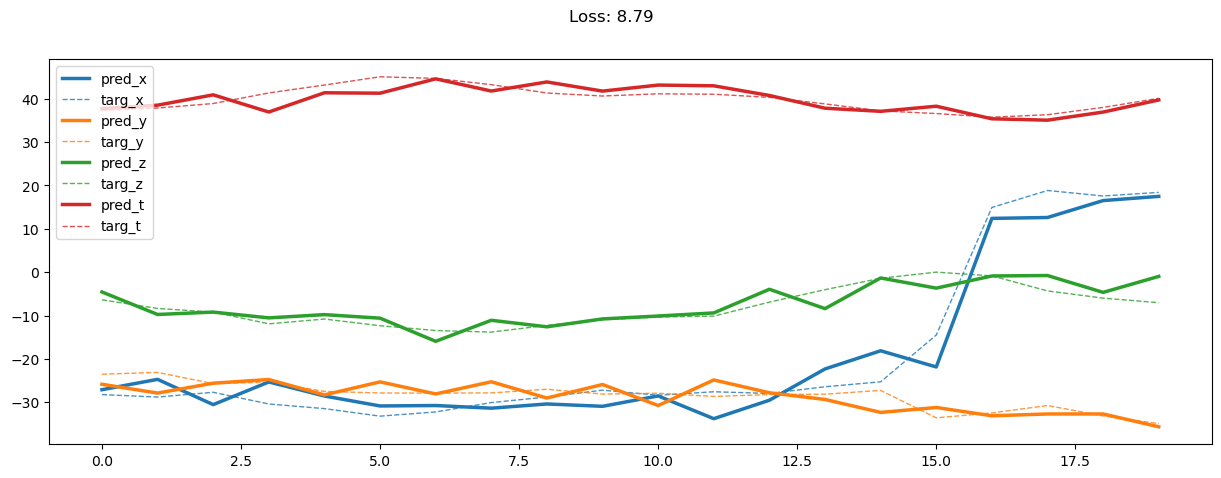

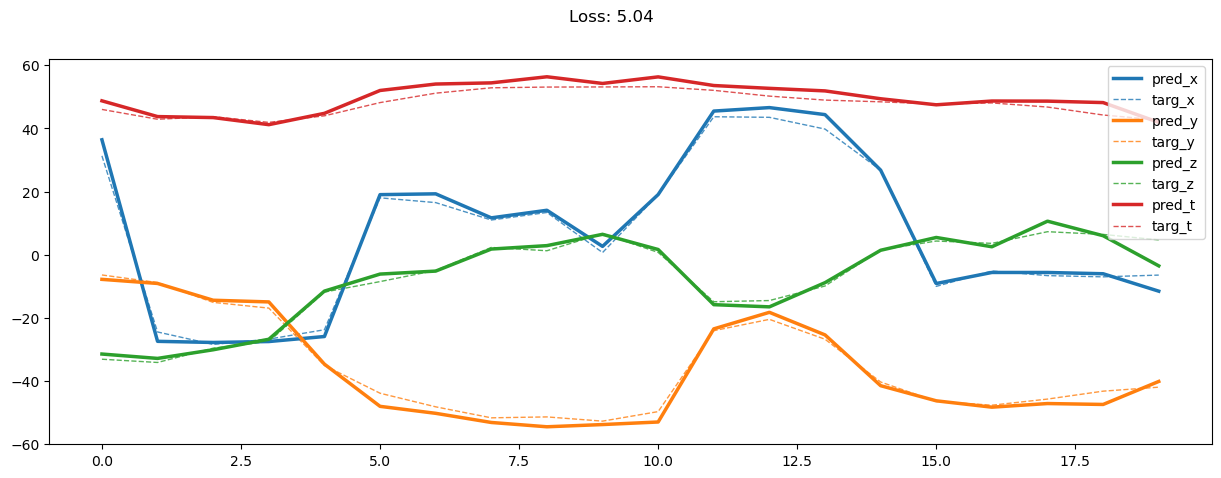

19000: train loss:  80.330, imu loss:  0.475, mag loss:  25.654, div loss:  51.181, slim:  4.511, tlim:  2.524
       valid loss:  35.075, imu loss:  0.453, mag loss:  11.491, div loss:  20.347, slim:  4.392, tlim:  2.248


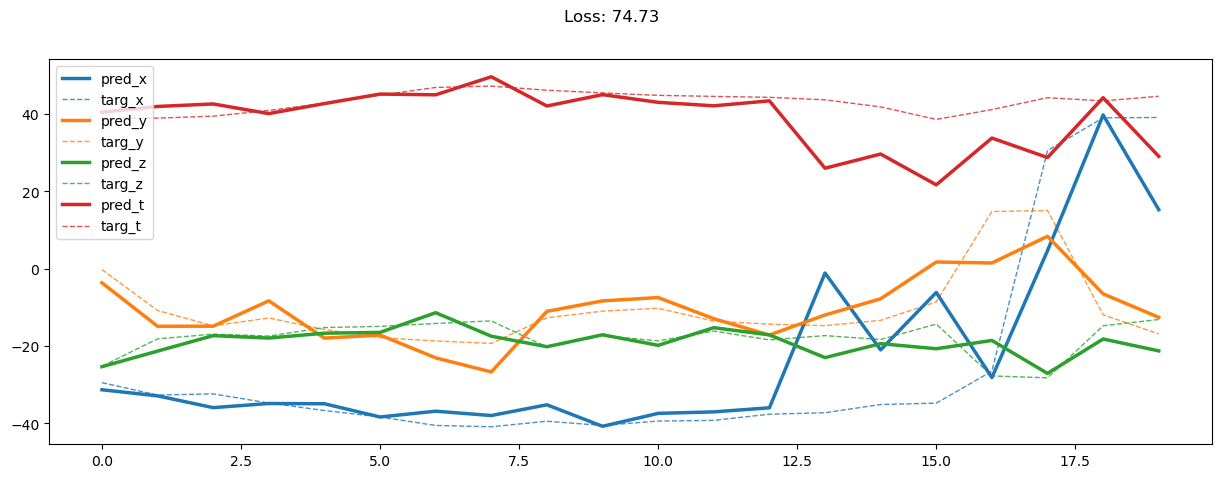

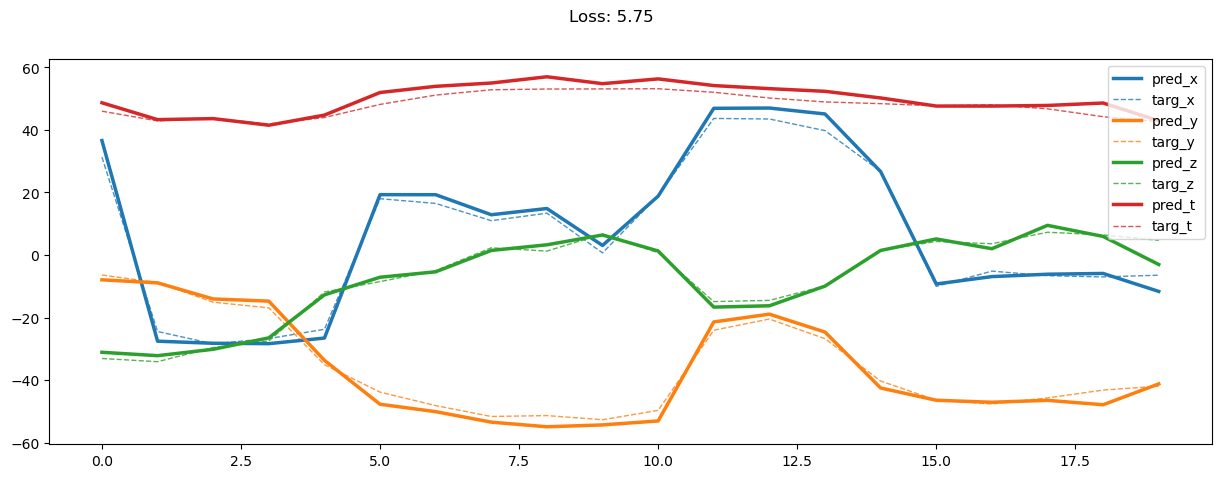

20000: train loss:  79.352, imu loss:  0.482, mag loss:  25.562, div loss:  50.282, slim:  4.532, tlim:  2.524
       valid loss:  35.574, imu loss:  0.451, mag loss:  11.685, div loss:  20.649, slim:  4.407, tlim:  2.249


In [31]:
EPOCH = 20000
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 1000 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 1000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')
    draw = False

In [35]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:14]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:14]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [36]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    15.43     9.91     5.53    10.29
     horizontal loss:    24.74    15.71     8.35    16.27
         pocket loss:    14.02     8.32     5.67     9.34
          swing loss:     8.04     6.40     4.44     6.29
        average loss:    15.56    10.08     6.00    10.55


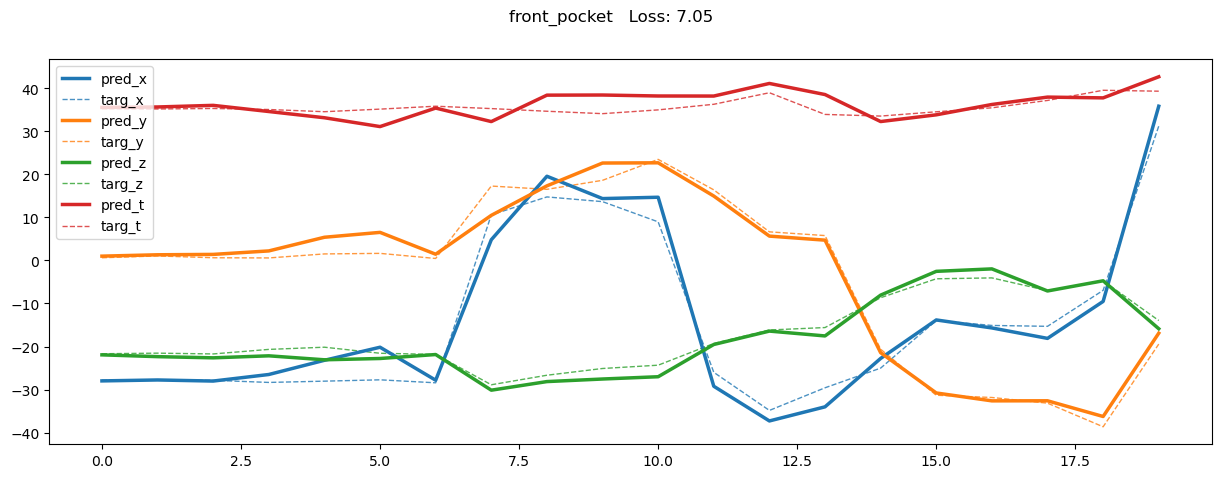

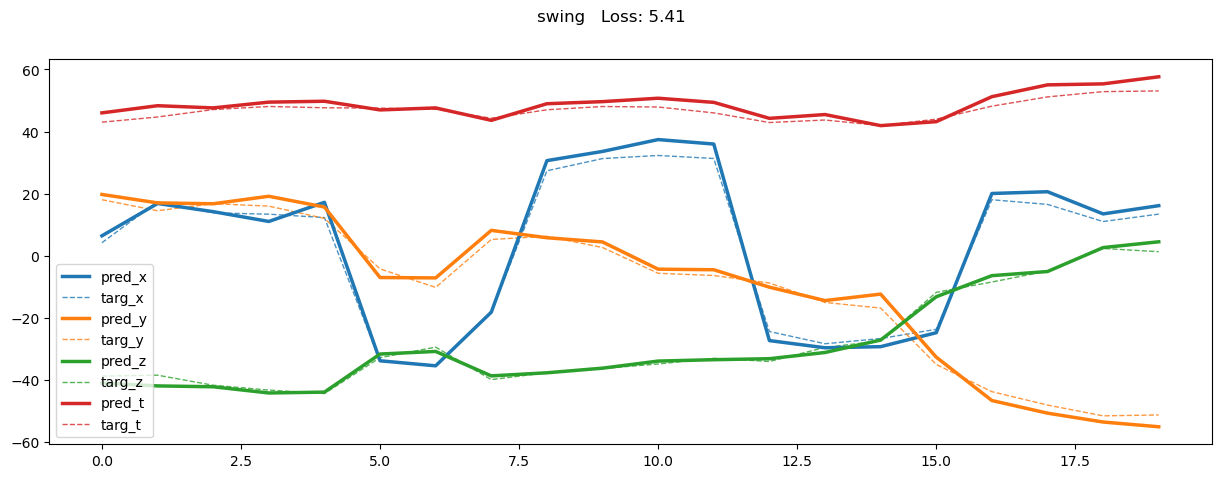

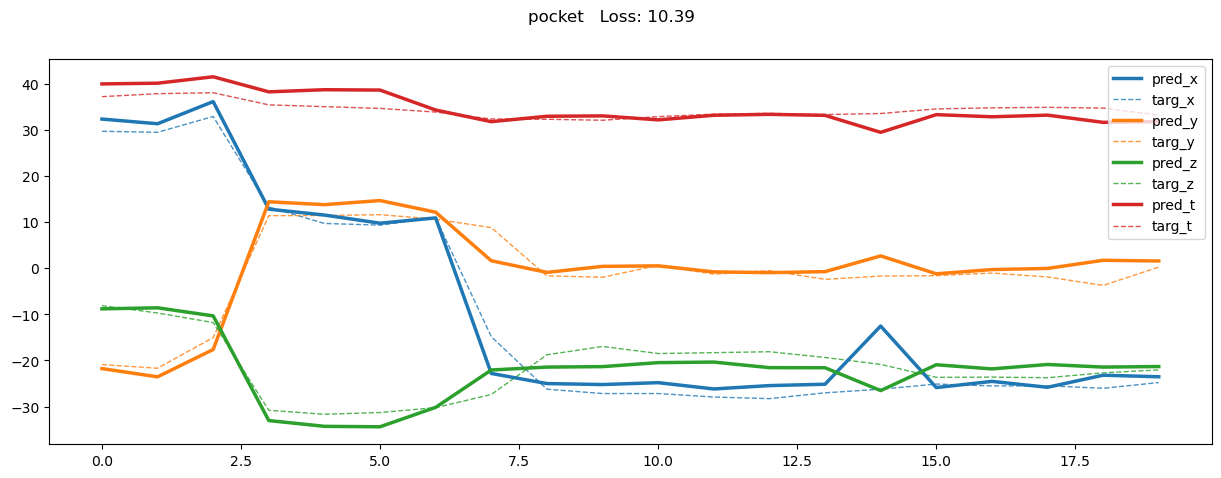

In [37]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    17.79    10.72     6.00    11.50
     horizontal loss:    27.29    16.75     8.79    17.61
         pocket loss:    19.31     9.48     6.23    11.67
          swing loss:     8.91     6.66     4.73     6.77
        average loss:    18.33    10.90     6.44    11.89


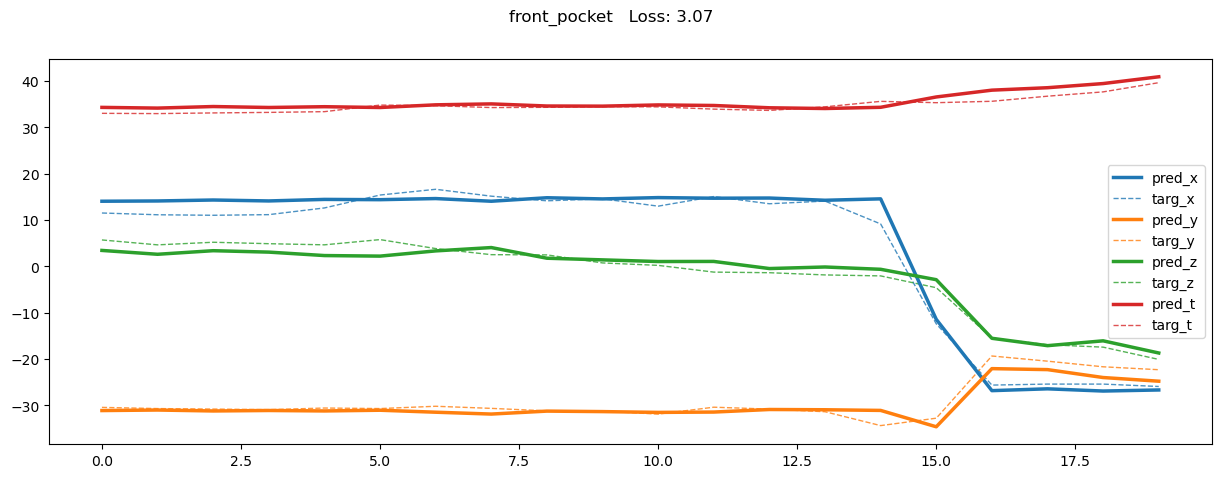

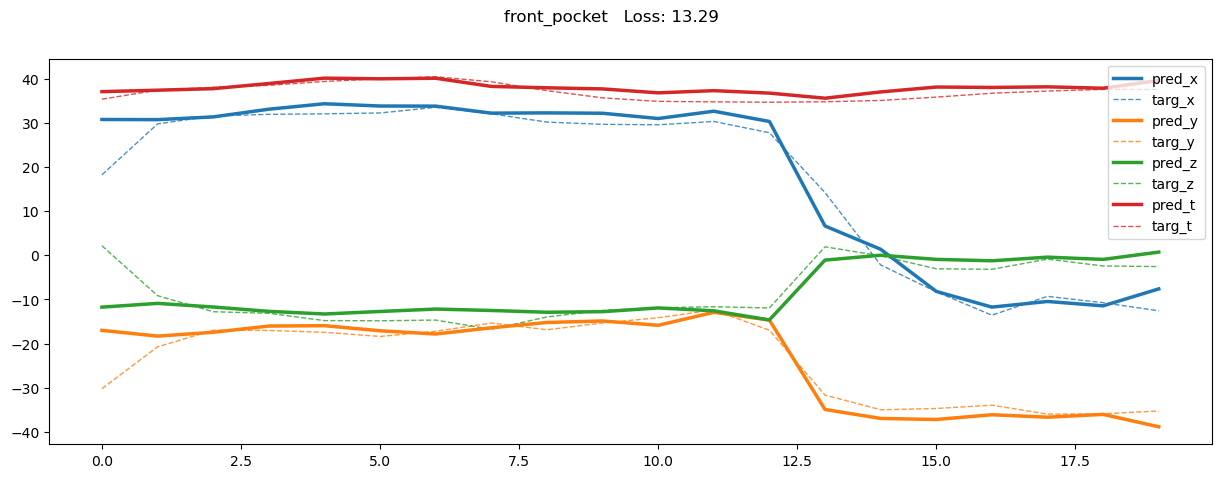

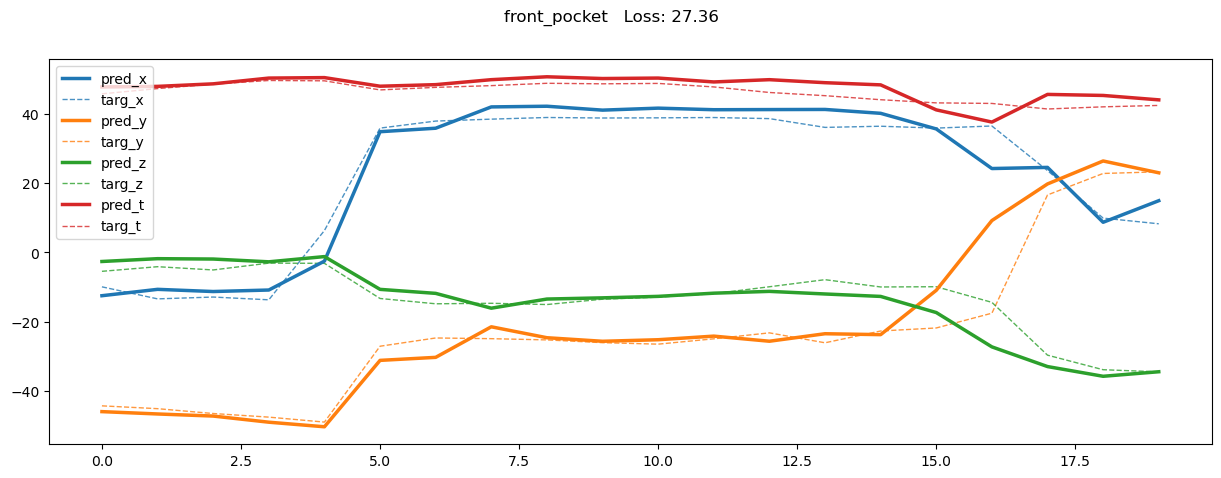

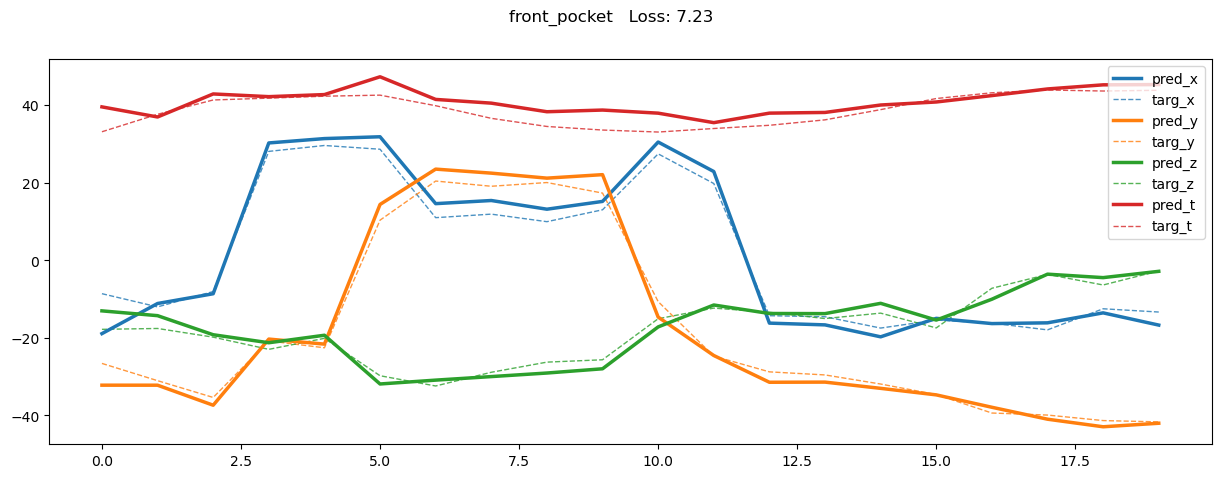

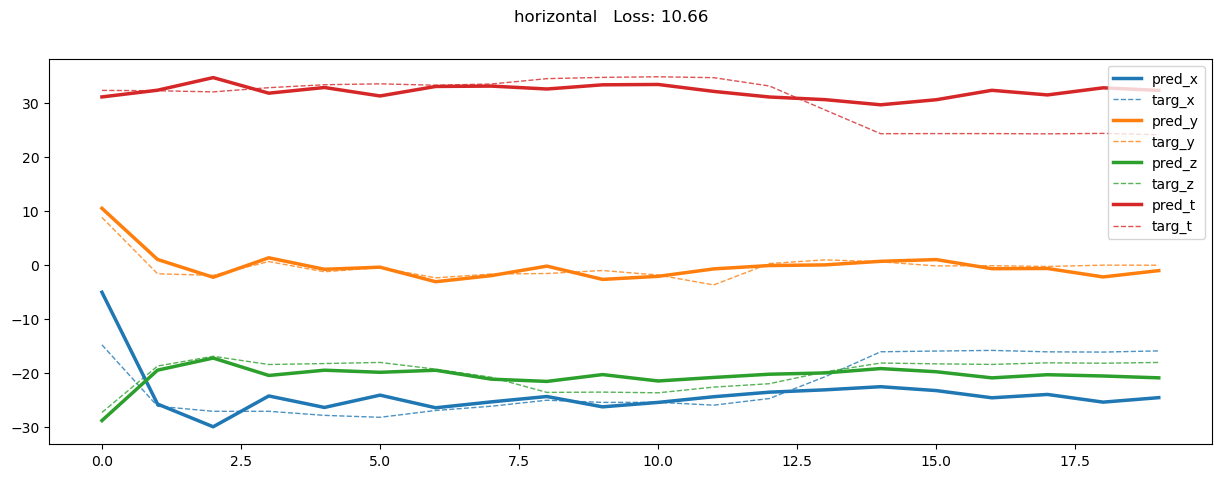

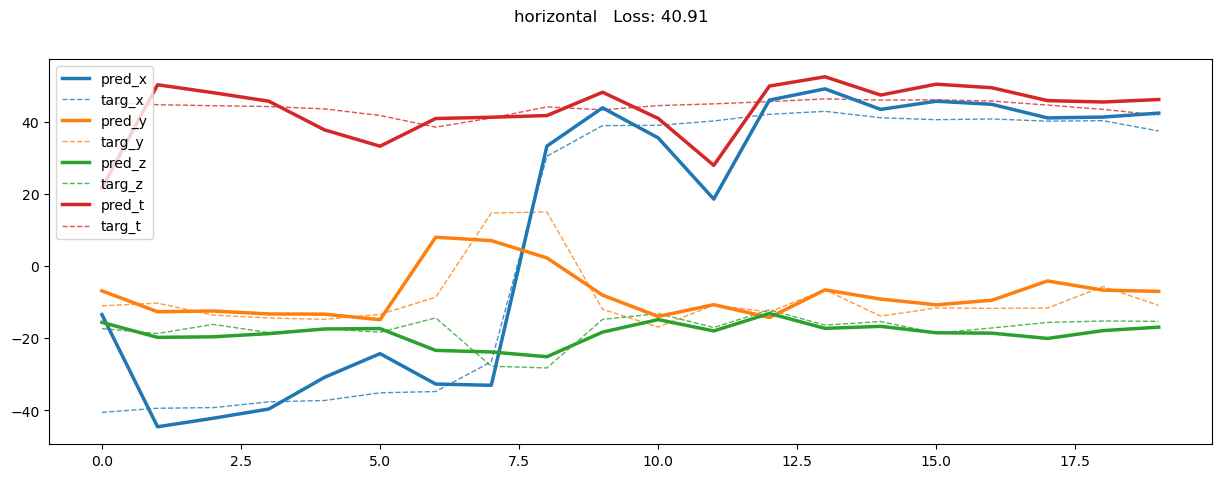

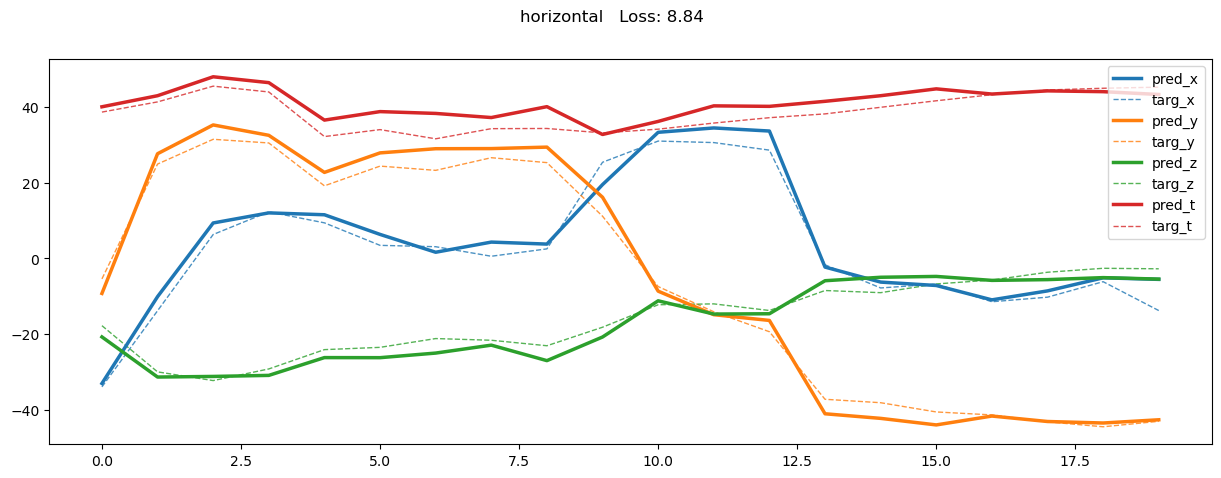

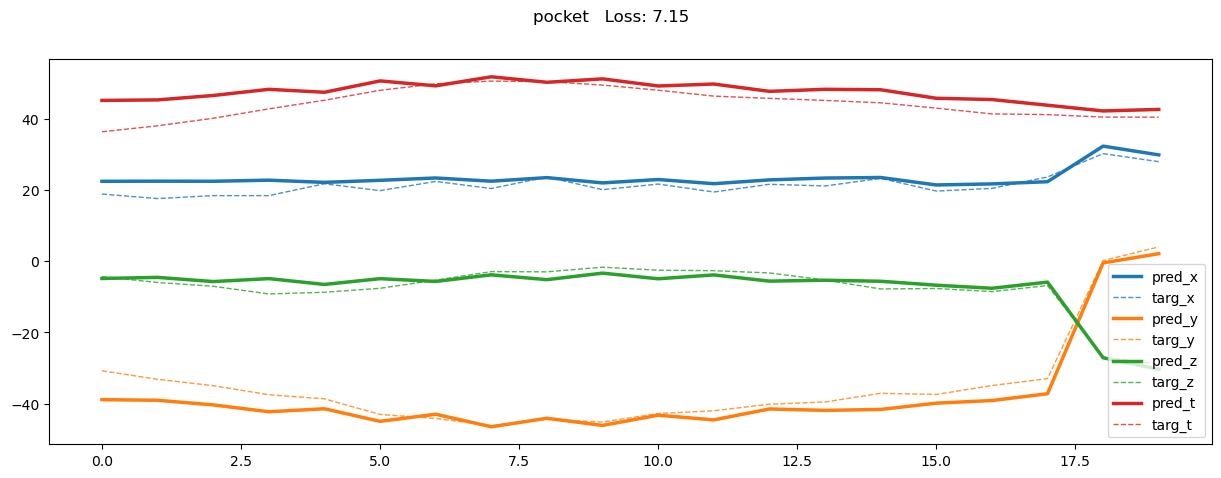

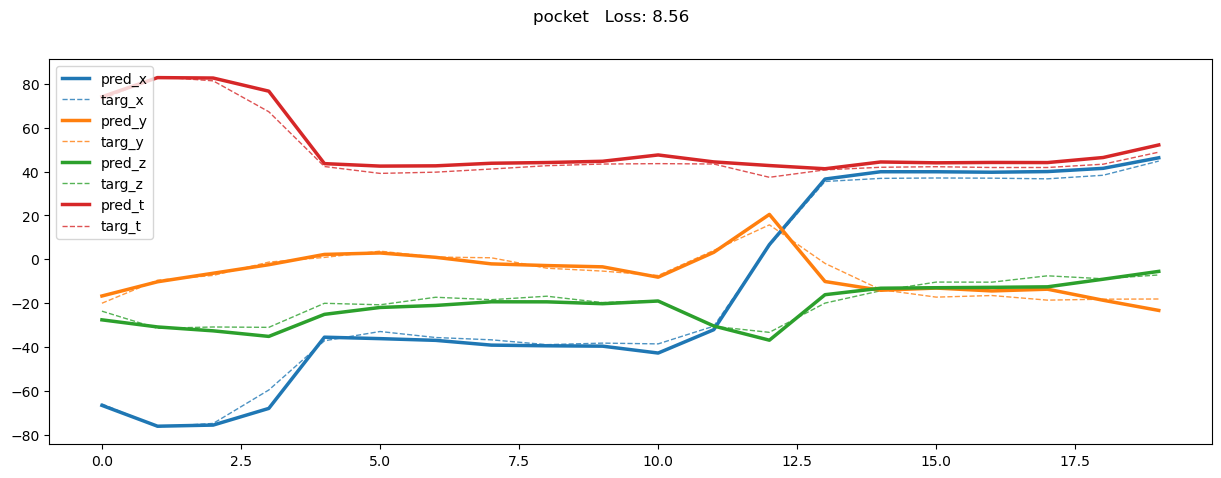

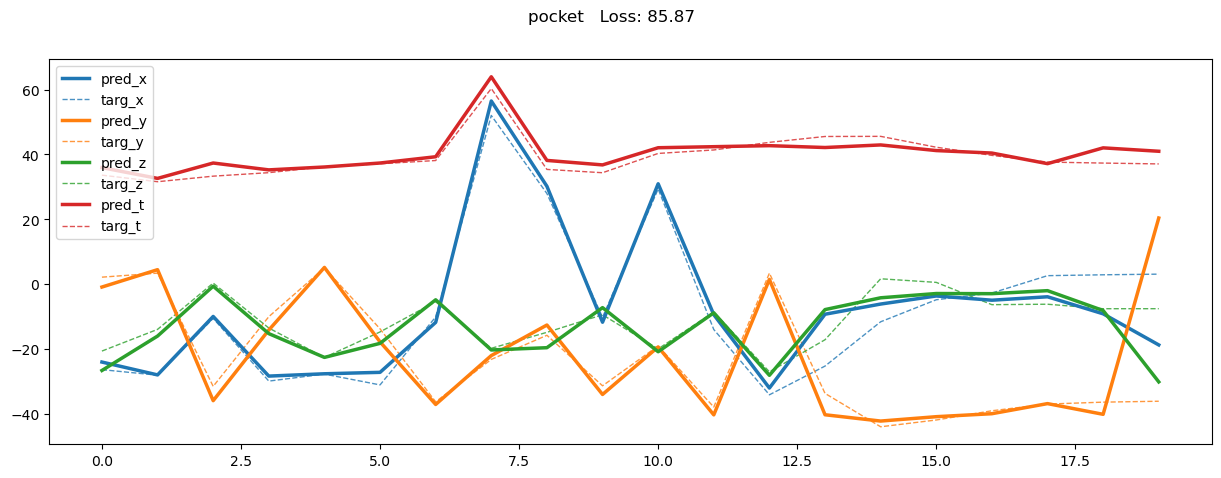

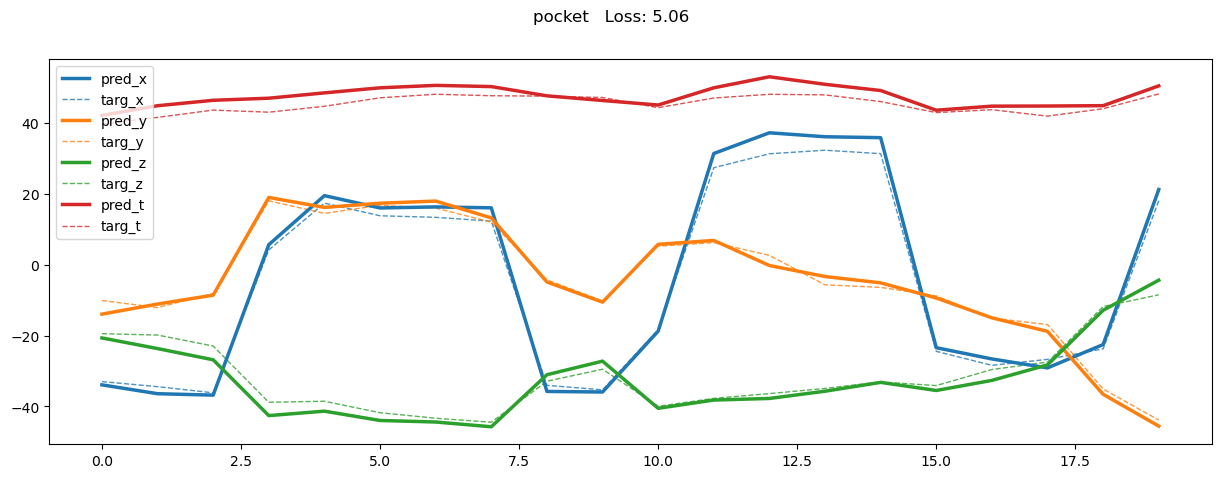

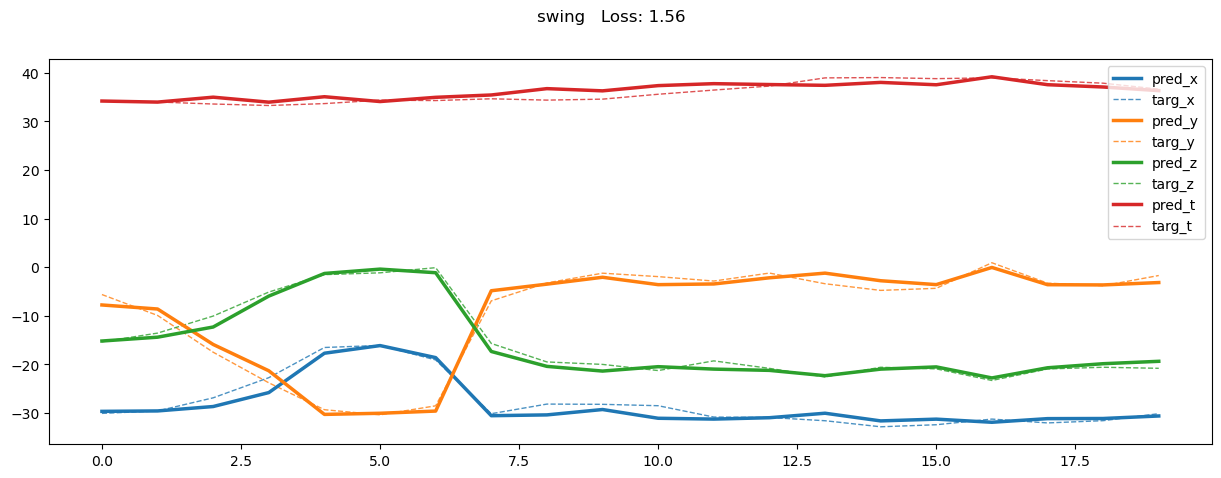

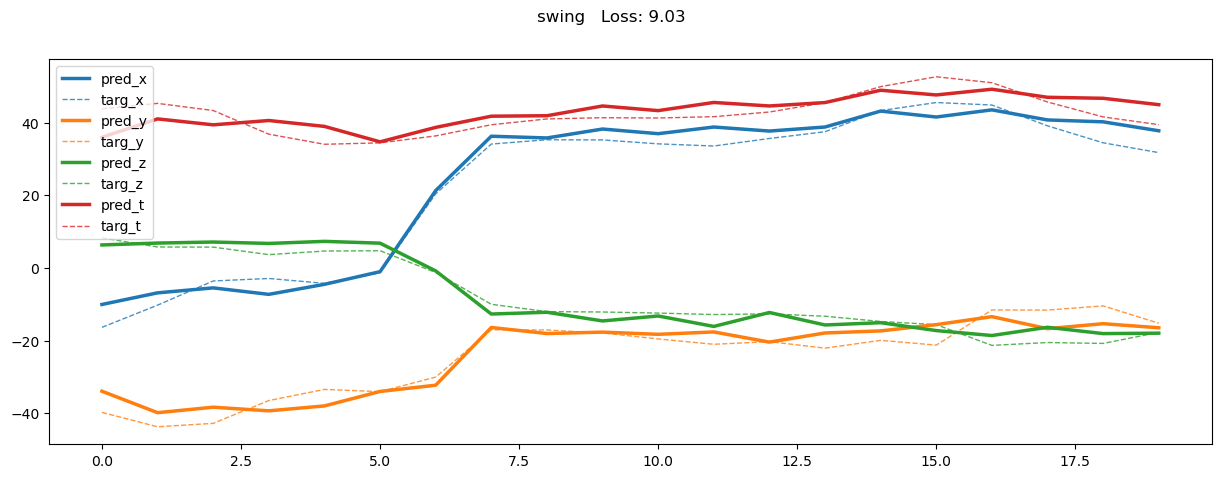

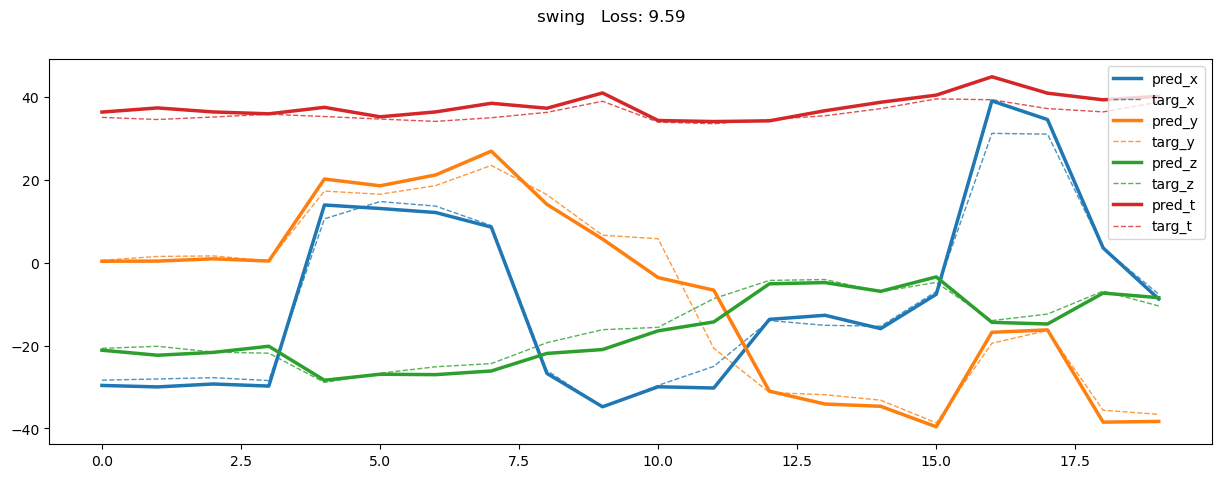

In [38]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)

In [39]:
# classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

In [40]:
pred_results = {}

get_posture = lambda x, y: np.concatenate((list(results[results[:, 2] == y, 3]), list(results[results[:, 2] == y, 0])), axis=-1)

pred_results['target'] = prep_valid_target_traj
pred_results['front_pocket'] = get_posture(results, 1)
pred_results['horizontal'] = get_posture(results, 2)
pred_results['pocket'] = get_posture(results, 3)
pred_results['swing'] = get_posture(results, 4)

In [41]:
pred_results['target'].shape, pred_results['front_pocket'].shape, pred_results['horizontal'].shape, pred_results['pocket'].shape, pred_results['swing'].shape

((674, 20, 15), (337, 20, 5), (337, 20, 5), (337, 20, 5), (337, 20, 5))

In [42]:
np.save(f'./pred_results.npy', pred_results)

In [43]:
np.save(f'./pred_swing_result.npy', pred_results['swing'])

In [44]:
np.save(f'./pred_pocket_result.npy', pred_results['pocket'])

In [45]:
np.save(f'./pred_horizontal_result.npy', pred_results['horizontal'])

In [46]:
np.save(f'./pred_front_pocket_result.npy', pred_results['front_pocket'])

In [47]:
def plot_eval_result(result, path):
    pred_mag = np.stack(results[:, 0], axis=0)[:, 0].reshape(-1, 3)
    targ_mag = np.stack(results[:, 1], axis=0)[:, 0].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(25, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{path}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [48]:
def load_data(name):
    return posture_data[name], posture_data['target']

def split_data(df):
    ncols = seq_len
    nrows = len(df) - seq_len + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    return df.to_numpy()[index]    

def combine_to_dataloader(source, target):
    dataset = PairDataset(
                        source_data = torch.tensor(source, dtype=torch.float),
                        source_label = np.zeros(len(source)),
                        target_data = torch.tensor(target, dtype=torch.float),
                        target_label = np.zeros(len(target)),
                    )
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    return dataloader

def generate_dataloader(name):
    source_df, target_df = load_data(name)
    source_segs, target_segs = split_data(source_df), split_data(target_df)

    return combine_to_dataloader(source_segs, target_segs)

In [49]:
for folder in ['./front_pocket/*', './pocket/*', './swing/*']:
    for path in glob.glob(folder):
        eval_loader = generate_dataloader(name)
        results, _, _ = output_eval(model, eval_loader)
        plot_eval_result(results, path)

In [50]:
torch.save(model, 'transformer.pt')

In [ ]:
model = torch.load('/root/Calibration/User_collection/transformer.pt')

In [ ]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

In [ ]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)